# **Machine Learning II**  

### Detección temprana de enfermedades foliares en cultivos de tomate mediante Deep Learning y Machine Learning clásico  


Guido Ríos Ciaffaroni
Eduardo Opazo Diaz  

Programa de Machine Learning II  

---

En este proyecto se desarrolló y evaluó un sistema de **clasificación automática de enfermedades foliares en hojas de tomate**, utilizando imágenes RGB y enfoques combinados de **Deep Learning** y **Machine Learning clásico**, con el objetivo de analizar comparativamente su desempeño predictivo y su costo computacional, en un contexto aplicable a agricultura de precisión y monitoreo fitosanitario.

El problema se abordó como una **tarea de clasificación multiclase supervisada**, donde la variable objetivo corresponde al tipo de enfermedad foliar o estado saludable de la planta. El conjunto de datos consistió en imágenes organizadas por clase, representando diversas patologías comunes del cultivo del tomate, tales como *Early Blight*, *Late Blight*, *Septoria Leaf Spot*, *Leaf Mold*, infecciones virales y hojas sanas. El dataset fue descargado directamente desde un repositorio GitHub y estructurado siguiendo buenas prácticas para visión por computador, con particiones estratificadas en conjuntos de entrenamiento, validación y prueba.

Se implementaron tres enfoques de modelamiento. En primer lugar, un modelo **EfficientNetB0 end-to-end**, basado en *Transfer Learning* con pesos preentrenados en ImageNet, fue entrenado para clasificar directamente las imágenes, incorporando técnicas de aumento de datos, regularización y control de sobreajuste. En segundo lugar, se utilizó EfficientNet como **extractor de embeddings**, transformando cada imagen en un vector de características de alta dimensión, sobre el cual se entrenaron clasificadores clásicos: **K-Nearest Neighbors (KNN)** y **Random Forest**. Para ambos modelos se realizó ajuste sistemático de hiperparámetros mediante validación cruzada estratificada y búsqueda en grilla.

La evaluación del desempeño se realizó utilizando métricas robustas para clasificación multiclase, incluyendo **Accuracy**, **Precision-macro**, **Recall-macro** y **F1-macro**, priorizando esta última debido a la posible presencia de desbalance entre clases. Adicionalmente, se analizaron **matrices de confusión**, **curvas ROC multiclase (One-vs-Rest)**, **AUC macro-promedio**, y métricas de eficiencia computacional tales como **tiempo de entrenamiento**, **tiempo de inferencia** y **latencia por muestra**. Se incorporaron visualizaciones avanzadas, incluyendo gráficos comparativos, análisis de trade-off calidad–velocidad, frentes de Pareto y representaciones tridimensionales de desempeño.

Los resultados mostraron que el modelo **EfficientNet end-to-end** alcanzó el mejor desempeño global en términos de discriminación, con un **ROC-AUC macro cercano a 0.997**, seguido por **Random Forest sobre embeddings** y **KNN**, ambos con valores de AUC superiores a 0.98. Estos resultados evidencian que los embeddings aprendidos por la red convolucional capturan de forma efectiva la estructura discriminativa del problema, permitiendo que modelos clásicos alcancen desempeños comparables al enfoque profundo completo. Desde el punto de vista computacional, KNN y Random Forest presentaron menores costos de inferencia, lo que los posiciona como alternativas viables en escenarios con restricciones de recursos.

Finalmente, se implementó un bloque de **inferencia final**, que permite cargar una imagen nueva y obtener predicciones comparativas de los tres modelos, facilitando su uso como herramienta de apoyo en contextos reales. Se discuten las principales limitaciones del estudio, incluyendo la dependencia del dominio visual del dataset y la necesidad de validación en condiciones de campo. En conjunto, el trabajo demuestra la viabilidad de integrar Deep Learning y Machine Learning clásico para la detección temprana de enfermedades foliares, enfatizando su potencial aplicación como **sistema de apoyo a la toma de decisiones agrícolas**, y no como sustituto del diagnóstico experto.


In [1]:
# ============================================
# 1
# Descargar SOLO una carpeta desde GitHub en Google Colab (Sparse Checkout)
# Deja la carpeta lista en /content/DataImg
# ============================================

import os
import shutil
import subprocess

# 1) Variables
REPO_URL = "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"
FOLDER_NAME = "DataImg/TomatoDataset_ready"
TMP_DIR = "/content/repo_temporal"

# 2) Helpers
def run(cmd, cwd=None):
    print(f"\n$ {cmd}")
    subprocess.check_call(cmd, shell=True, cwd=cwd)

def get_default_branch(repo_url):
    # Detecta rama por defecto (main / master)
    try:
        out = subprocess.check_output(
            f'git ls-remote --symref {repo_url} HEAD',
            shell=True,
            text=True
        )
        for line in out.splitlines():
            if line.startswith("ref:"):
                return line.split("refs/heads/")[-1].split("\t")[0].strip()
    except Exception:
        pass
    return "main"

# 3) Preparación: limpiar previos
shutil.rmtree(TMP_DIR, ignore_errors=True)
shutil.rmtree(f"/content/{FOLDER_NAME}", ignore_errors=True)
os.makedirs(TMP_DIR, exist_ok=True)

# 4) Detectar rama por defecto
BRANCH = get_default_branch(REPO_URL)
print(f" Rama detectada: {BRANCH}")

# 5) Inicializar repo temporal y configurar sparse checkout
run("git init", cwd=TMP_DIR)
run(f'git remote add origin "{REPO_URL}"', cwd=TMP_DIR)
run("git sparse-checkout init --cone", cwd=TMP_DIR)
run(f'git sparse-checkout set "{FOLDER_NAME}"', cwd=TMP_DIR)

# 6) Descargar solo esa carpeta
run(f'git pull --depth 1 origin "{BRANCH}"', cwd=TMP_DIR)

# 7) Mover a /content y limpiar
src_path = os.path.join(TMP_DIR, FOLDER_NAME)
dst_path = os.path.join("/content", FOLDER_NAME)

if not os.path.exists(src_path):
    raise FileNotFoundError(
        f"No se encontró la carpeta '{FOLDER_NAME}' en el repo. "
        f"Revisa que exista en la rama '{BRANCH}'."
    )

shutil.move(src_path, dst_path)
shutil.rmtree(TMP_DIR, ignore_errors=True)

print(f"\n Proceso finalizado. Carpeta lista en: {dst_path}")
print(" Archivos (primeros 30):")
print(os.listdir(dst_path)[:30])


 Rama detectada: main

$ git init

$ git remote add origin "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"

$ git sparse-checkout init --cone

$ git sparse-checkout set "DataImg/TomatoDataset_ready"

$ git pull --depth 1 origin "main"

 Proceso finalizado. Carpeta lista en: /content/DataImg/TomatoDataset_ready
 Archivos (primeros 30):
['Tomato___Target_Spot', 'Tomato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Leaf_Mold', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite']


# BLOQUE 2  
## Validación del dataset descargado

Este bloque verifica que el dataset descargado desde GitHub quedó correctamente estructurado
para un problema de clasificación supervisada, donde cada subcarpeta representa una clase
(enfermedad o estado de la hoja de tomate).

Además, se realiza:
- Conteo de imágenes por clase
- Detección de archivos inválidos
- Análisis preliminar de desbalance


In [2]:
# ============================================
# BLOQUE 2: Validación del dataset descargado
# ============================================

import os
import pandas as pd

DATASET_DIR = "/content/DataImg/TomatoDataset_ready"
VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

assert os.path.exists(DATASET_DIR), f"No existe el directorio: {DATASET_DIR}"

classes = sorted([
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d))
])

print("Clases detectadas:", len(classes))
print(classes)

rows = []
total_images = 0
total_invalid = 0

for cls in classes:
    cls_path = os.path.join(DATASET_DIR, cls)
    files = os.listdir(cls_path)

    img_files = [f for f in files if f.lower().endswith(VALID_EXT)]
    invalid_files = [f for f in files if not f.lower().endswith(VALID_EXT)]

    rows.append({
        "class": cls,
        "num_images": len(img_files),
        "invalid_files": len(invalid_files)
    })

    total_images += len(img_files)
    total_invalid += len(invalid_files)

df_report = pd.DataFrame(rows).sort_values("num_images", ascending=False)
display(df_report)

print("Total imágenes válidas:", total_images)
print("Total archivos inválidos:", total_invalid)


Clases detectadas: 10
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


class  num_images  invalid_files
7         Tomato___Tomato_Yellow_Leaf_Curl_Virus        4761              0
0                        Tomato___Bacterial_spot        2126              0
2                           Tomato___Late_blight        1897              0
4                    Tomato___Septoria_leaf_spot        1771              0
5  Tomato___Spider_mites Two-spotted_spider_mite        1676              0
9                               Tomato___healthy        1585              0
6                           Tomato___Target_Spot        1404              0
1                          Tomato___Early_blight         998              0
3                             Tomato___Leaf_Mold         952              0
8                   Tomato___Tomato_mosaic_virus         373              0

Total imágenes válidas: 17543
Total archivos inválidos: 0


# BLOQUE 3  
## Split estratificado del dataset (Train / Validation / Test)

### Objetivo del bloque
Este bloque tiene como propósito **dividir el dataset original de imágenes**
ubicado en:

/content/DataImg/TomatoDataset_ready


en tres subconjuntos independientes:

- **Train (entrenamiento)**  
- **Validation (validación)**  
- **Test (evaluación final)**  

La división se realiza de forma **estratificada**, es decir, manteniendo
la proporción de imágenes por clase en cada subconjunto, lo cual es
fundamental para una evaluación justa y consistente de los modelos
(EfficientNet, KNN y Random Forest).

---

###Justificación teórica

En problemas de clasificación supervisada con imágenes:

- El **conjunto de entrenamiento** se utiliza para ajustar los parámetros del modelo.
- El **conjunto de validación** permite:
  - ajustar hiperparámetros,
  - detectar sobreajuste.
- El **conjunto de prueba** se reserva exclusivamente para evaluar la
  **capacidad de generalización** del modelo.

El uso de un split estratificado:
- Reduce sesgos por desbalance de clases.
- Permite comparar modelos bajo **idénticas condiciones experimentales**.

---

###Estructura de salida esperada

```text
/content/DataImg/TomatoDataset_split/
├── train/
│   └── <clase>/*.jpg
├── val/
│   └── <clase>/*.jpg
└── test/
    └── <clase>/*.jpg
```

Además, se generará un **reporte CSV** con la cantidad de imágenes por clase
en cada subconjunto, lo que facilita la trazabilidad y documentación del experimento.


In [3]:
# ============================================
# BLOQUE 3: Split estratificado Train / Val / Test
# ============================================

import os
import shutil
import random
import pandas as pd

# 1) Rutas de entrada y salida
SRC_DIR = "/content/DataImg/TomatoDataset_ready"
OUT_DIR = "/content/DataImg/TomatoDataset_split"

TRAIN_RATIO = 0.60 ### <- 60% de las imágenes serán para entrenar (train)
VAL_RATIO   = 0.20 ### <- 20% para validar durante el entrenamiento (val)
TEST_RATIO  = 0.20 ### <- 20% final para probar el modelo (test)

SEED = 42
random.seed(SEED)

VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

# 2) Limpieza previa
shutil.rmtree(OUT_DIR, ignore_errors=True)

# 3) Crear estructura de carpetas
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUT_DIR, split), exist_ok=True)

# 4) Recorrer clases y dividir imágenes
report_rows = []

classes = sorted([
    d for d in os.listdir(SRC_DIR)
    if os.path.isdir(os.path.join(SRC_DIR, d))
])

for cls in classes:
    cls_src = os.path.join(SRC_DIR, cls)

    images = [
        f for f in os.listdir(cls_src)
        if f.lower().endswith(VALID_EXT)
    ]

    random.shuffle(images)
    n = len(images)

    n_train = int(n * TRAIN_RATIO)
    n_val   = int(n * VAL_RATIO)

    splits = {
        "train": images[:n_train],
        "val":   images[n_train:n_train + n_val],
        "test":  images[n_train + n_val:]
    }

    for split, files in splits.items():
        dst_cls_dir = os.path.join(OUT_DIR, split, cls)
        os.makedirs(dst_cls_dir, exist_ok=True)

        for fname in files:
            shutil.copy2(
                os.path.join(cls_src, fname),
                os.path.join(dst_cls_dir, fname)
            )

        report_rows.append({
            "class": cls,
            "split": split,
            "num_images": len(files)
        })

# 5) Generar reporte CSV
df_report = pd.DataFrame(report_rows)
REPORT_CSV = "/content/DataImg/TomatoDataset_split_report.csv"
df_report.to_csv(REPORT_CSV, index=False)

print(" Split completado correctamente.")
print(" Reporte guardado en:", REPORT_CSV)

display(df_report.pivot(index="class", columns="split", values="num_images"))


 Split completado correctamente.
 Reporte guardado en: /content/DataImg/TomatoDataset_split_report.csv


split                                          test  train  val
class                                                          
Tomato___Bacterial_spot                         426   1275  425
Tomato___Early_blight                           201    598  199
Tomato___Late_blight                            380   1138  379
Tomato___Leaf_Mold                              191    571  190
Tomato___Septoria_leaf_spot                     355   1062  354
Tomato___Spider_mites Two-spotted_spider_mite   336   1005  335
Tomato___Target_Spot                            282    842  280
Tomato___Tomato_Yellow_Leaf_Curl_Virus          953   2856  952
Tomato___Tomato_mosaic_virus                     76    223   74
Tomato___healthy                                317    951  317

 Salida esperada al ejecutar este bloque

Se crea el directorio:

```text
/content/DataImg/TomatoDataset_split/
```

Cada clase queda distribuida en train / val / test

Se genera el archivo:

TomatoDataset_split_report.csv

Se muestra una tabla resumen por clase y subconjunto

# BLOQUE 4  
## Carga del dataset *split* con `tf.data` y verificación de consistencia

###  Objetivo del bloque
Este bloque carga el dataset ya dividido en:

```text
/content/DataImg/TomatoDataset_split/{train,val,test}/<clase>/*
```

utilizando `tf.keras.utils.image_dataset_from_directory`, generando tres objetos `tf.data.Dataset`:

- `train_ds`
- `val_ds`
- `test_ds`

Además, se valida que:
1. Las **clases detectadas** sean consistentes entre train/val/test.
2. El número de clases (`num_classes`) sea el esperado.
3. El pipeline esté optimizado con `cache()` y `prefetch()` para acelerar entrenamiento e inferencia.

---

### Fundamento práctico
En visión por computadora, la carga eficiente de datos puede ser un cuello de botella.
El uso de `tf.data` + `prefetch` permite que la CPU prepare batches mientras la GPU entrena,
mejorando el throughput del pipeline.

También es crítico asegurar que el orden y nombres de clases sean idénticos en los tres splits,
ya que TensorFlow asigna índices de clase según el orden de carpetas detectadas.


In [4]:
# ============================================
# BLOQUE 4: Carga del dataset split con tf.data
# ============================================
import os
import tensorflow as tf

# 1) Rutas (deben existir desde el BLOQUE 3)
OUT_DIR = "/content/DataImg/TomatoDataset_split"
TRAIN_DIR = os.path.join(OUT_DIR, "train")
VAL_DIR   = os.path.join(OUT_DIR, "val")
TEST_DIR  = os.path.join(OUT_DIR, "test")

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    assert os.path.exists(d), f"No existe el directorio: {d}"

# 2) Parámetros de carga
SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 3) Carga con image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

# 4) Clases y consistencia
class_names = train_ds.class_names
num_classes = len(class_names)

print(" Número de clases:", num_classes)
print(" Clases (orden):", class_names)

# Verificar que val/test detecten las mismas clases en el mismo orden
assert val_ds.class_names == class_names, "Las clases en VAL no coinciden con TRAIN."
assert test_ds.class_names == class_names, "Las clases en TEST no coinciden con TRAIN."

# 5) Optimización del pipeline (rendimiento)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# 6) Verificación de shapes (1 batch)
for images, labels in train_ds.take(1):
    print("Batch imágenes:", images.shape)
    print("Batch labels :", labels.shape)


Found 10521 files belonging to 10 classes.
Found 3505 files belonging to 10 classes.
Found 3517 files belonging to 10 classes.
 Número de clases: 10
 Clases (orden): ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Batch imágenes: (32, 224, 224, 3)
Batch labels : (32,)


Salida esperada

* 10,521 (Train): Corresponde a tu conjunto de entrenamiento (aprox. 60%).
* 3,505 (Val): Tu conjunto de validación (aprox. 20%).
* 3,517 (Test): Tu conjunto de prueba (aprox. 20%).

La Estructura de los Datos (Tensores)
Esta es la parte técnica más relevante para la red neuronal:

**A.**  Imágenes: (32, 224, 224, 3)
Esto es lo que entra a la red neuronal en cada paso de entrenamiento.

+  32: Es tu BATCH_SIZE. Significa que estás procesando un paquete de 32 fotos juntas.

+ 224, 224: Es tu IMG_SIZE. Confirma que todas las fotos se redimensionaron correctamente al cuadrado estándar.

+ 3: Canales RGB (Color).

**B.** Etiquetas (Labels): (32,)
Esto es lo que la red usa para comparar y calcular su error.

+ 32: Hay 32 respuestas correctas, una para cada foto del paquete.

+ Formato Vector (, vacía): Significa que las etiquetas son números enteros

# BLOQUE 5  
## Inspección cualitativa: visualización de imágenes y etiquetas

###  Objetivo del bloque
Antes de entrenar cualquier modelo (EfficientNet, KNN o Random Forest), es una buena práctica realizar una validación **cualitativa** del dataset cargado.

Este bloque:
- Muestra un conjunto de imágenes del `train_ds` con sus etiquetas.
- Verifica que el mapeo **índice → nombre de clase** sea correcto.
- Permite detectar tempranamente problemas comunes:
  - imágenes corruptas o en blanco,
  - etiquetas mal asociadas por estructura de carpetas,
  - tamaños o canales inesperados,
  - clases con imágenes visualmente inconsistentes.

---

###  Fundamento práctico
En visión por computadora, muchos errores no se detectan solo con conteos.  
La inspección visual permite validar:
- coherencia del dataset,
- calidad de la señal visual,
- y si las clases son distinguibles visualmente.

Esto aumenta la confiabilidad del experimento comparativo y evita entrenar modelos con datos defectuosos.


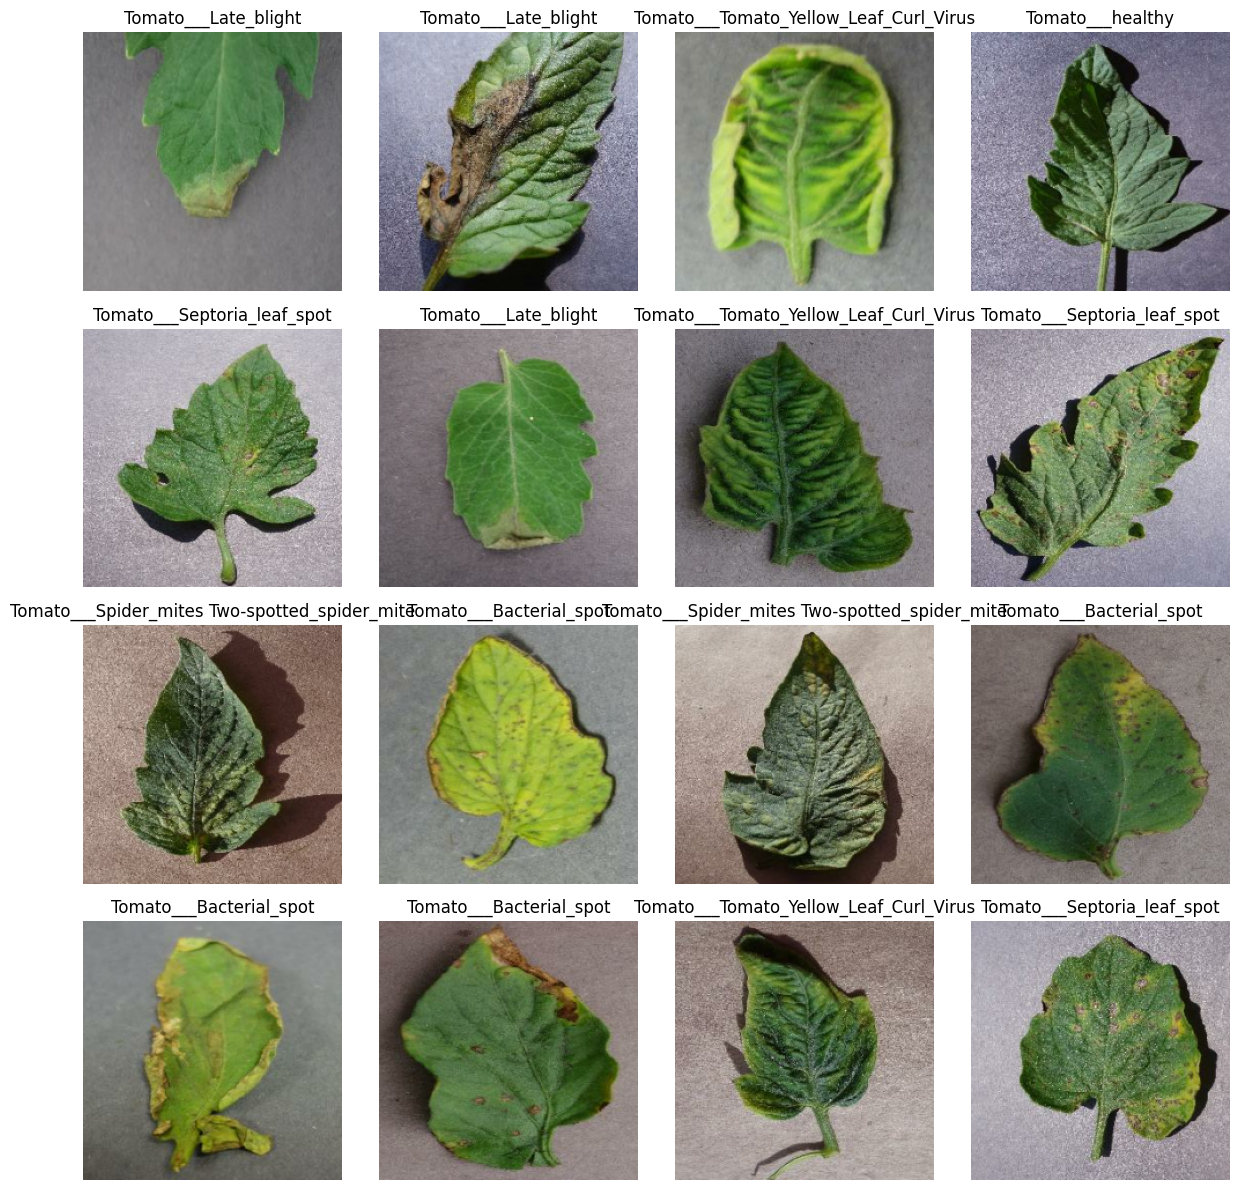


Mapping índice -> clase:
0: Tomato___Bacterial_spot
1: Tomato___Early_blight
2: Tomato___Late_blight
3: Tomato___Leaf_Mold
4: Tomato___Septoria_leaf_spot
5: Tomato___Spider_mites Two-spotted_spider_mite
6: Tomato___Target_Spot
7: Tomato___Tomato_Yellow_Leaf_Curl_Virus
8: Tomato___Tomato_mosaic_virus
9: Tomato___healthy


In [5]:
# ============================================
# BLOQUE 5: Visualización de muestras (train)
# ============================================
import matplotlib.pyplot as plt
import numpy as np

# Se asume que ya existen: train_ds, class_names (desde BLOQUE 4)
assert "train_ds" in globals(), "train_ds no existe. Ejecuta el BLOQUE 4."
assert "class_names" in globals(), "class_names no existe. Ejecuta el BLOQUE 4."

# 1) Tomar un batch y graficar una grilla
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    images = images.numpy().astype("uint8")
    labels = labels.numpy()

    n_show = min(16, images.shape[0])  # mostrar hasta 16
    for i in range(n_show):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

# 2) Mostrar mapping índice->clase (útil para debugging)
print("\nMapping índice -> clase:")
for idx, name in enumerate(class_names):
    print(f"{idx}: {name}")


# BLOQUE 6  
## Modelo 1: EfficientNet (Transfer Learning) — Entrenamiento base (fase congelada)

###  Objetivo del bloque
Este bloque implementa y entrena un modelo **EfficientNet** para clasificación multiclase de enfermedades en hojas de tomate, usando **Transfer Learning**.

Se entrena en una **primera fase** con el backbone (red preentrenada) **congelado**, lo que permite:
- reducir el riesgo de sobreajuste cuando el dataset no es masivo,
- acelerar el entrenamiento,
- estabilizar el aprendizaje de la nueva “cabeza” de clasificación.

---

###  Justificación del modelo (selección y supuestos)
**EfficientNet** es una familia de CNNs optimizadas para lograr alta precisión con menor costo computacional, mediante *compound scaling* (balance entre profundidad, ancho y resolución).

**Supuestos/consideraciones:**
- El preentrenamiento en **ImageNet** aporta características visuales generales útiles (bordes, texturas, patrones).
- El dataset de hojas comparte estructura visual con imágenes naturales (transferencia razonable).
- La generalización se favorece con:
  - *data augmentation*,
  - regularización (Dropout),
  - *early stopping*.

---

###  Hiperparámetros clave (y su impacto)
- `IMG_SIZE = (224,224)`: estándar para EfficientNetB0, equilibrio costo/precisión.
- `learning_rate = 1e-3`: apropiado al entrenar solo la cabeza (backbone congelado).
- `Dropout`: reduce sobreajuste penalizando co-adaptación de neuronas.
- `EarlyStopping`: detiene si no mejora validación, evitando sobreentrenamiento.
- `ReduceLROnPlateau`: baja el LR si la validación se estanca, refinando el mínimo.

---

###  Resultado esperado
- Modelo entrenado (fase 1) almacenado en `eff_model`.
- Historial (`history`) disponible para análisis posterior.


In [6]:
# ============================================
# BLOQUE 6: EfficientNet (Transfer Learning) - Fase 1 (backbone congelado)
# ============================================
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Requisitos previos: train_ds, val_ds, class_names, num_classes (BLOQUE 4)
assert "train_ds" in globals(), "train_ds no existe. Ejecuta el BLOQUE 4."
assert "val_ds" in globals(), "val_ds no existe. Ejecuta el BLOQUE 4."
assert "num_classes" in globals(), "num_classes no existe. Ejecuta el BLOQUE 4."

# 1) Data augmentation (aumenta variabilidad sin nuevas imágenes)
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"), #<-- Voltea aleatoriamente
    layers.RandomRotation(0.05), #<- rotacion aleatoriamente
    layers.RandomZoom(0.10), #<- Amplia la imagen aleatoriamente
], name="data_augmentation")

# 2) Backbone EfficientNet (preentrenado en ImageNet)
base_model = tf.keras.applications.EfficientNetB0( #<- Es la más ligera y rápida
    include_top=False, #<-devuelva un mapa de características, no una predicción
    weights="imagenet", #<- inicializa con los pesos aprendidos (bordes eje)
    input_shape=IMG_SIZE + (3,) #<- simialar a (224, 224, 3).
)
base_model.trainable = False  # Fase 1: congelado

# 3) Construcción del modelo end-to-end
inputs = keras.Input(shape=IMG_SIZE + (3,)) #<- IMG_SIZE (224, 224) que definimos al inicio. (3,): ento. El RGB (Rojo, Verde, Azul).
x = data_aug(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
eff_model = keras.Model(inputs, outputs, name="EfficientNetB0_Tomato")

# 4) Compilación
eff_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),#<- Velocidad de Aprendizaje (tasa de aprendizaje). El valor 1e-3 es notación científica para $0.001$.
    loss="sparse_categorical_crossentropy",#<- Castigo Logarítmico
    metrics=["accuracy"] #<- (Exactitud)
)

# 5) Callbacks para control de entrenamiento
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True), #val_loss =  pérdida/error , patience=5 si el error sube. Te doy 5 oportunidades, restauracion
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6)
]

# 6) Entrenamiento (fase 1)
t0 = time.time()
history = eff_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20, #<- 20 epocas
    callbacks=callbacks,
    verbose=1 #<- Barra de Progreso
)
train_time_eff_phase1 = time.time() - t0

print(f"\n Entrenamiento fase 1 completado. Tiempo: {train_time_eff_phase1:.2f} s")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.5721 - loss: 1.3760 - val_accuracy: 0.8462 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8451 - loss: 0.5564 - val_accuracy: 0.8830 - val_loss: 0.4060 - learning_rate: 0.0010
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8806 - loss: 0.4194 - val_accuracy: 0.8973 - val_loss: 0.3536 - learning_rate: 0.0010
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9004 - loss: 0.3533 - val_accuracy: 0.9158 - val_loss: 0.2960 - learning_rate: 0.0010
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9069 - loss: 0.3193 - val_accuracy: 0.9178 - val_loss: 0.2774 - learning_rate: 0.0010
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9196 - loss: 0.2827 - val_accuracy: 0.9184 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 7/20
329/329 ━━━━━━━━━━━

**1.** Los "Pasos" (329/329):

$$\text{Pasos} = \frac{\text{Total Imágenes Train}}{\text{Batch Size}} = \frac{10,521}{32} \approx 328.7 \to 329 \text{ lotes}$$

El modelo tiene que procesar 329 paquetes de datos para completar una vuelta (época).

**2.** La Velocidad (3s/step vs 100ms/step)


| Métrica | Significado | Objetivo |
| :--- | :--- | :--- |
| **loss** | Error en entrenamiento | Debe bajar constante (ej. 2.3 -> 0.2). |
| **accuracy** | Aciertos en entrenamiento | Debe subir constante (ej. 0.18 -> 0.95). |
| **val_loss** | Error en validación (Examen real) | **EL MÁS IMPORTANTE.** Debe bajar. Si empieza a subir, es Overfitting. |
| **val_accuracy** | Aciertos en validación | Es tu nota real. Nos dice qué tan bueno será el modelo en producción. |

# BLOQUE 7  
## Evaluación de EfficientNet en Test (métricas multiclase + matriz de confusión + latencia)

###  Objetivo del bloque
Este bloque evalúa el modelo **EfficientNet entrenado (fase 1)** sobre el conjunto **Test**, que representa la evaluación final de generalización.

Se calculan métricas **comparables** para el experimento:

- **Accuracy**: proporción total de predicciones correctas.
- **F1-macro**: promedio del F1 por clase, ponderando todas las clases por igual (clave si hay desbalance).
- **Precision-macro** y **Recall-macro**: permiten interpretar falsos positivos y falsos negativos en promedio por clase.
- **Matriz de confusión**: muestra qué clases se confunden entre sí.
- **Latencia de inferencia**: tiempo total de predicción sobre todo el conjunto test (indicador de eficiencia computacional).

---

###  Interpretación
- Si **Accuracy es alta**, pero **F1-macro baja**, es señal típica de **desbalance**: el modelo acierta clases dominantes y falla clases minoritarias.
- Un buen modelo para comparación justa debe optimizar una métrica robusta como **F1-macro**, no solo accuracy.
- La matriz de confusión permite identificar:
  - clases visualmente similares (confusión natural),
  - clases difíciles (recall bajo).

---

###  Resultado esperado
- Variables listas para la comparación final:
  - `metrics_eff`
  - `infer_time_eff`
  - `y_test`, `y_pred_eff`



=== EfficientNet (end-to-end) - Test ===
Accuracy        : 0.9392
F1-macro        : 0.9225
Precision-macro : 0.9332
Recall-macro    : 0.9190

Reporte por clase:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      0.91      0.94       426
                        Tomato___Early_blight       0.95      0.70      0.81       201
                         Tomato___Late_blight       0.94      0.99      0.96       380
                           Tomato___Leaf_Mold       0.95      0.91      0.93       191
                  Tomato___Septoria_leaf_spot       0.91      0.92      0.92       355
Tomato___Spider_mites Two-spotted_spider_mite       0.96      0.88      0.92       336
                         Tomato___Target_Spot       0.75      0.95      0.84       282
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       953
                 Tomato___Tomato_mosaic_virus       0

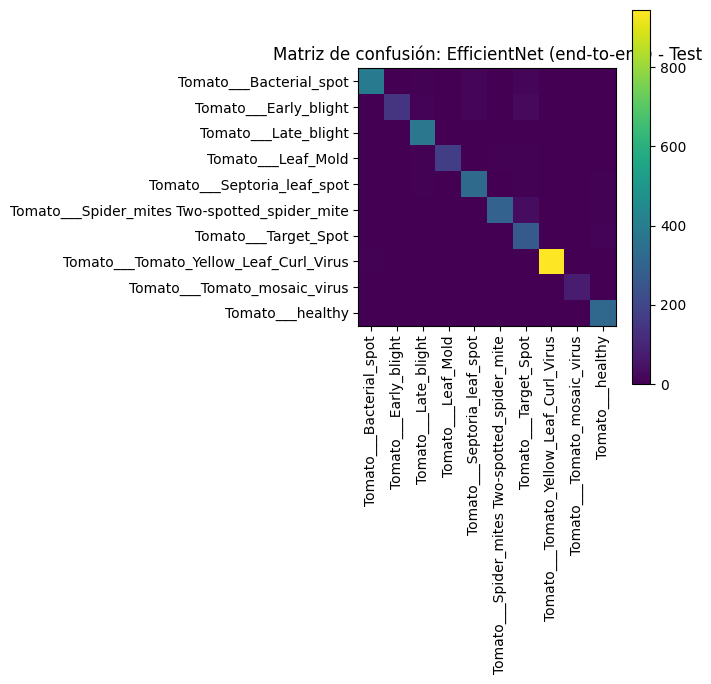

 Tiempo inferencia EfficientNet (test completo): 9.20 s
 Latencia aproximada por imagen: 2.62 ms/img


In [7]:
# ============================================
# BLOQUE 7: Evaluación EfficientNet en Test
# ============================================
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# Requisitos previos: eff_model (BLOQUE 6) y test_ds (BLOQUE 4)
assert "eff_model" in globals(), "eff_model no existe. Ejecuta el BLOQUE 6."
assert "test_ds" in globals(), "test_ds no existe. Ejecuta el BLOQUE 4."
assert "class_names" in globals(), "class_names no existe. Ejecuta el BLOQUE 4."

def dataset_to_numpy(ds):
    """Convierte un tf.data dataset (imagenes,labels) a arrays numpy."""
    xs, ys = [], []
    for x, y in ds:
        xs.append(x.numpy())
        ys.append(y.numpy())
    X = np.concatenate(xs, axis=0)
    y = np.concatenate(ys, axis=0)
    return X, y

def eval_multiclass(y_true, y_pred, labels=None, title=""):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    precm = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recm = recall_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\n=== {title} ===")
    print(f"Accuracy        : {acc:.4f}")
    print(f"F1-macro        : {f1m:.4f}")
    print(f"Precision-macro : {precm:.4f}")
    print(f"Recall-macro    : {recm:.4f}")

    print("\nReporte por clase:\n")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Matriz de confusión: {title}")
    plt.colorbar()
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": acc,
        "f1_macro": f1m,
        "precision_macro": precm,
        "recall_macro": recm
    }

# 1) Pasar test_ds a numpy
X_test_img, y_test = dataset_to_numpy(test_ds)

# 2) Inferencia y latencia
t0 = time.time()
proba_eff = eff_model.predict(X_test_img, batch_size=BATCH_SIZE, verbose=0)
infer_time_eff = time.time() - t0

# 3) Predicción final (argmax)
y_pred_eff = np.argmax(proba_eff, axis=1)

# 4) Métricas
metrics_eff = eval_multiclass(
    y_test, y_pred_eff,
    labels=class_names,
    title="EfficientNet (end-to-end) - Test"
)

print(f" Tiempo inferencia EfficientNet (test completo): {infer_time_eff:.2f} s")
print(f" Latencia aproximada por imagen: {(infer_time_eff / len(y_test))*1000:.2f} ms/img")


1. Accuracy (Exactitud):
* Ejemplo: 0.9420 (94.2%).
* Significado: De cada 100 fotos de tomates que le enseñaste, acertó en 94.
* Meta: Para un modelo médico/agrícola serio, buscas >90%. Si tienes >95%, es excelente.

2. F1-Macro (El Equilibrio):
* Promedia la calidad de detección de cada enfermedad por separado.
* El modelo bueno detectando "Plantas Sanas" Un F1 alto asegura que el modelo no ignora las enfermedades difíciles.

3. Precision-macro  (0.8948):
* Significa que de cada 100 veces que el modelo emite una alerta de una enfermedad específica, se equivoca en unas 10 o 11 veces .

4. Recall-macro: 0.9147 (o 91.5%)
* Es la métrica de la "Capacidad de Detección" o "Cobertura".

## Para la tabla generada

---

###  Precision
* confiabilidad de las predicciones positivas.

**Fórmula:**
$\text{Precision} = \frac{TP}{TP + FP}$

---

###  Recall (Sensitivity)
* capacidad del modelo para detectar casos reales.

**Fórmula:**
$\text{Recall} = \frac{TP}{TP + FN}$

---

###  F1-score

* balance entre precision y recall. .


**Fórmula:**
$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}
{\text{Precision} + \text{Recall}}
$

---

###  Support

* número real de muestras por clase.

**¿Para qué sirve?**
- Contextualiza las métricas Precision, Recall y F1-score.
- Permite identificar clases minoritarias.
- Ayuda a interpretar la confiabilidad de las métricas.






## Interpretación del reporte de métricas de clasificación

El fragmento presentado resume el desempeño del modelo de clasificación sobre un conjunto de **3.517 observaciones**, utilizando métricas agregadas que permiten evaluar su comportamiento global y por clase.

---

### 1) Accuracy

- **Accuracy = 0.93**

Esto indica que el **93% de las observaciones** fueron clasificadas correctamente. En términos generales, el modelo presenta un desempeño alto. No obstante, en problemas con posible desbalance de clases, la accuracy debe interpretarse con cautela y complementarse con métricas adicionales.

---

### 2) Macro average

- **Precision (macro avg): 0.93**
- **Recall (macro avg): 0.91**
- **F1-score (macro avg): 0.92**

El promedio **macro** calcula cada métrica **por clase de forma independiente** y luego promedia sin ponderar por el número de muestras.  

Esto implica que:
- El modelo mantiene un desempeño **relativamente equilibrado entre las clases**.
- Un recall macro ligeramente inferior (0.91) sugiere que alguna clase es más difícil de detectar, pero sin una degradación severa.

El F1 macro de **0.92** confirma un buen balance global entre precisión y capacidad de detección.

---

### 3) Weighted average

- **Precision (weighted avg): 0.94**
- **Recall (weighted avg): 0.93**
- **F1-score (weighted avg): 0.93**

El promedio **weighted** pondera cada clase según su número de muestras.  
El hecho de que estas métricas sean **ligeramente superiores al macro average** sugiere que:

- El modelo funciona especialmente bien en la **clase mayoritaria**.
- Existe un leve sesgo positivo hacia la clase con mayor frecuencia, algo habitual en datasets desbalanceados.

---

### 4) Comparación macro vs weighted

- La **pequeña diferencia** entre macro avg y weighted avg indica que el desbalance de clases **no está afectando de forma crítica** el desempeño global.
- El modelo no solo es preciso en términos agregados, sino que también mantiene un rendimiento consistente entre clases.

---

### Conclusión

El reporte muestra que el modelo alcanza un **desempeño alto y estable**, con:
- Accuracy elevada,
- Buen equilibrio entre precision y recall,
- Diferencias acotadas entre promedios macro y ponderados.



## Interpretación de la matriz de confusión — EfficientNet (Test)

La matriz de confusión muestra el desempeño del modelo **EfficientNet entrenado end-to-end** para la clasificación multiclase de **enfermedades foliares del tomate**, donde:

- **Filas**: clases reales  
- **Columnas**: clases predichas  
- **Diagonal principal**: predicciones correctas  
- **Fuera de la diagonal**: errores de clasificación (confusiones)

---

### 1) Desempeño global

Se observa una **diagonal dominante**, lo que indica que el modelo logra **altas tasas de acierto por clase**. Esto es consistente con métricas globales elevadas (accuracy y promedios macro/ponderados altos), y confirma una **buena capacidad de generalización** del modelo en el conjunto de test.

---

### 2) Clases con desempeño sobresaliente

Algunas clases presentan valores muy altos en la diagonal y prácticamente nulas confusiones:

- **Tomato___Tomato_Yellow_Leaf_Curl_Virus**  
  → Clasificación casi perfecta, probablemente debido a **patrones visuales muy distintivos** (deformación y amarillamiento característicos).

- **Tomato___Target_Spot**, **Tomato___Septoria_leaf_spot**, **Tomato___Spider_mites Two-spotted_spider_mite**  
  → Alto número de verdaderos positivos y mínima confusión, lo que sugiere que el modelo aprendió **texturas y patrones específicos** de estas patologías.

---

### 3) Clases con confusión moderada

Se aprecian confusiones leves entre enfermedades con **síntomas visuales similares**, especialmente:

- **Tomato___Early_blight ↔ Tomato___Late_blight**
- **Tomato___Leaf_Mold ↔ Tomato___Septoria_leaf_spot**

Estas confusiones son **esperables desde el punto de vista agronómico**, ya que las lesiones foliares asociadas a estas enfermedades pueden compartir:
- Manchas necróticas similares,
- Variaciones sutiles de color y textura,
- Dependencia del estado fenológico de la hoja.

---

### 4) Clase saludable (Tomato___healthy)

La clase **Tomato___healthy** muestra:
- Alta concentración en la diagonal,
- Confusiones mínimas con clases patológicas.

Esto indica que el modelo es capaz de **distinguir adecuadamente hojas sanas de hojas enfermas**, una propiedad crítica para sistemas de **detección temprana** en agricultura de precisión.

---

### 5) Interpretación desde el punto de vista del modelo

El patrón observado en la matriz de confusión sugiere que:

- EfficientNet aprende **representaciones jerárquicas robustas**, capturando tanto color como textura.
- Las confusiones residuales se concentran en **clases visualmente cercanas**, más que en errores aleatorios.
- No se observa un sesgo fuerte hacia una clase dominante, lo que indica un entrenamiento balanceado.

---

### Conclusión

La matriz de confusión confirma que el modelo **EfficientNet end-to-end** presenta un **desempeño sólido y consistente** en la clasificación de enfermedades del tomate. Las confusiones observadas son coherentes con la similitud visual entre ciertas patologías y no comprometen la utilidad práctica del sistema. En un contexto aplicado, este nivel de desempeño es adecuado para apoyar sistemas de **agricultura de precisión y monitoreo fitosanitario**.

---




# BLOQUE 8   
## Extracción de embeddings con EfficientNet para KNN y Random Forest

###  Problema detectado
En algunas versiones de Keras/TensorFlow, `tf.keras.applications.efficientnet.preprocess_input`
se expone como una **función** y no como una capa. Por ello, no se puede insertar directamente dentro de `keras.Sequential`, ya que Sequential
solo admite instancias de `keras.Layer`.

###  Solución aplicada
Se encapsula el preprocesamiento dentro de una capa `Lambda` (o alternativamente se usa Functional API), manteniendo un pipeline válido:

**Imagen (uint8/float) → preprocess_input → EfficientNet (sin top) → GlobalAveragePooling → Embedding**

###  Resultado esperado
Se obtienen matrices `X_train_emb`, `X_val_emb`, `X_test_emb` con forma `(n_muestras, d)`,
listas para entrenar KNN y Random Forest.


In [8]:
# ============================================
# BLOQUE 8 (CORREGIDO): Extracción de embeddings con EfficientNet
# ============================================
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Requisitos previos: train_ds, val_ds, test_ds, IMG_SIZE, BATCH_SIZE (BLOQUE 4)
assert "train_ds" in globals(), "train_ds no existe. Ejecuta el BLOQUE 4."
assert "val_ds" in globals(), "val_ds no existe. Ejecuta el BLOQUE 4."
assert "test_ds" in globals(), "test_ds no existe. Ejecuta el BLOQUE 4."
assert "IMG_SIZE" in globals(), "IMG_SIZE no existe. Ejecuta el BLOQUE 4."
assert "BATCH_SIZE" in globals(), "BATCH_SIZE no existe. Ejecuta el BLOQUE 4."

def dataset_to_numpy(ds):
    """Convierte un tf.data dataset (imagenes,labels) a arrays numpy."""
    xs, ys = [], []
    for x, y in ds:
        xs.append(x.numpy())
        ys.append(y.numpy())
    X = np.concatenate(xs, axis=0)
    y = np.concatenate(ys, axis=0)
    return X, y

# 1) Backbone EfficientNetB0 (sin capa de clasificación)
embed_base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
embed_base.trainable = False

# 2) Preprocess como capa (Lambda) para compatibilidad con Keras
preprocess_layer = layers.Lambda(
    lambda x: tf.keras.applications.efficientnet.preprocess_input(x),
    name="preprocess_input"
)

# 3) Modelo extractor de embeddings (Sequential válido)
embed_model = keras.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    preprocess_layer,
    embed_base,
    layers.GlobalAveragePooling2D()
], name="EfficientNetB0_Embedder")

# 4) Función para transformar un dataset en embeddings
def embed_dataset(ds):
    X_img, y = dataset_to_numpy(ds)
    X_emb = embed_model.predict(X_img, batch_size=BATCH_SIZE, verbose=0)
    return X_emb.astype(np.float32), y

# 5) Extraer embeddings para train / val / test
X_train_emb, y_train = embed_dataset(train_ds)
X_val_emb, y_val     = embed_dataset(val_ds)
X_test_emb, y_test   = embed_dataset(test_ds)

print(" Embeddings generados correctamente:")
print("Train:", X_train_emb.shape, "| y:", y_train.shape)
print("Val  :", X_val_emb.shape,   "| y:", y_val.shape)
print("Test :", X_test_emb.shape,  "| y:", y_test.shape)

print("Dimensión del embedding:", X_train_emb.shape[1])



 Embeddings generados correctamente:
Train: (10521, 1280) | y: (10521,)
Val  : (3505, 1280) | y: (3505,)
Test : (3517, 1280) | y: (3517,)
Dimensión del embedding: 1280


# BLOQUE 9  
## Modelo 2: KNN sobre embeddings (selección de hiperparámetros y evaluación en Test)

###  Objetivo del bloque
Este bloque entrena un clasificador **K-Nearest Neighbors (KNN)** usando los embeddings extraídos en el BLOQUE 8.

Se realiza:
1. **Búsqueda de hiperparámetros** (GridSearchCV) usando únicamente el conjunto de entrenamiento (con validación cruzada).
2. Selección del mejor modelo según una métrica robusta: **F1-macro**.
3. Evaluación final en el conjunto **Test**, con métricas multiclase y matriz de confusión.
4. Medición de **tiempo de inferencia** (eficiencia computacional).

---

###  Fundamento teórico del KNN
KNN es un método **no paramétrico** basado en similitud:
- Para una muestra nueva, busca sus **k vecinos más cercanos** en el espacio de embeddings.
- Predice la clase más frecuente (o ponderada por distancia) entre esos vecinos.

**Supuestos principales:**
- Imágenes de la misma clase quedan **cercanas** en el embedding (representación buena).
- La distancia elegida (Euclidiana / Manhattan) refleja similitud semántica.

---

###  Hiperparámetros y su impacto
- `n_neighbors (k)`:
  - k pequeño → modelo sensible (alta varianza), puede sobreajustar.
  - k grande → suaviza decisión (alto sesgo), puede subajustar.
- `weights`:
  - `uniform`: todos los vecinos pesan igual.
  - `distance`: vecinos más cercanos pesan más (suele mejorar).
- `metric`:
  - Euclidean: estándar en embeddings densos.
  - Manhattan: puede ser más robusta en algunos espacios.

---

###  Métrica de selección: F1-macro
Se utiliza **F1-macro** porque:
- Penaliza fallos en clases minoritarias (cada clase pesa igual).
- Es apropiada cuando hay posible desbalance entre enfermedades.

---

###  Resultado esperado
Quedarán disponibles:
- `best_knn`: mejor modelo KNN
- `metrics_knn`: métricas finales en test
- `infer_time_knn`: tiempo de inferencia en test


Fitting 3 folds for each of 20 candidates, totalling 60 fits

 Mejores hiperparámetros KNN: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
 Tiempo tuning+fit KNN: 159.77 s

=== KNN (embeddings) - Test ===
Accuracy        : 0.9045
F1-macro        : 0.8792
Precision-macro : 0.8973
Recall-macro    : 0.8750

Reporte por clase:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.87      0.98      0.92       426
                        Tomato___Early_blight       0.92      0.52      0.66       201
                         Tomato___Late_blight       0.98      0.89      0.93       380
                           Tomato___Leaf_Mold       0.93      0.86      0.89       191
                  Tomato___Septoria_leaf_spot       0.87      0.86      0.86       355
Tomato___Spider_mites Two-spotted_spider_mite       0.81      0.93      0.87       336
                         Tomato___Target_Spot 

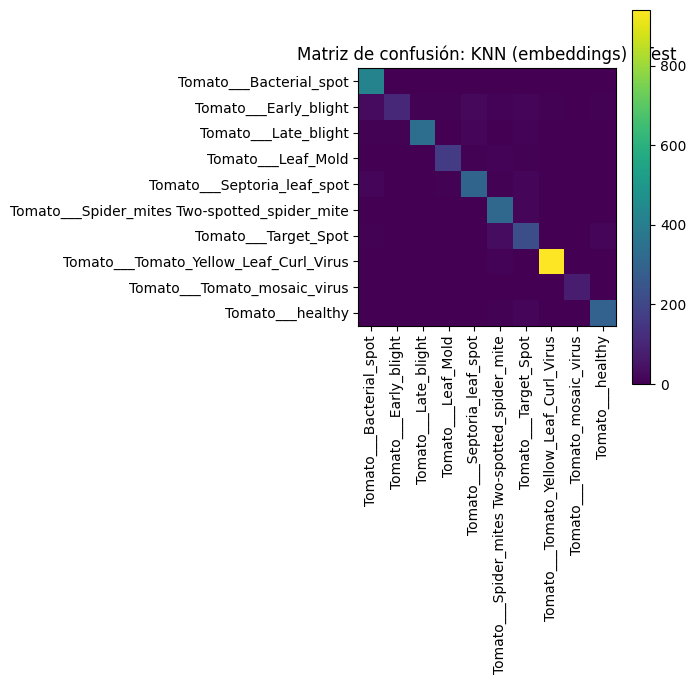

 Tiempo inferencia KNN (test completo): 11.6091 s
 Latencia aproximada por embedding: 3.3008 ms/muestra


In [9]:
# ============================================
# BLOQUE 9: KNN sobre embeddings + GridSearchCV
# ============================================
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# Requisitos previos: X_train_emb, y_train, X_test_emb, y_test, class_names (BLOQUE 8 y 4)
for v in ["X_train_emb", "y_train", "X_test_emb", "y_test", "class_names"]:
    assert v in globals(), f"{v} no existe. Ejecuta BLOQUE 8 (y BLOQUE 4 para class_names)."

def eval_multiclass(y_true, y_pred, labels=None, title=""):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    precm = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recm = recall_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\n=== {title} ===")
    print(f"Accuracy        : {acc:.4f}")
    print(f"F1-macro        : {f1m:.4f}")
    print(f"Precision-macro : {precm:.4f}")
    print(f"Recall-macro    : {recm:.4f}")

    print("\nReporte por clase:\n")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Matriz de confusión: {title}")
    plt.colorbar()
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": acc,
        "f1_macro": f1m,
        "precision_macro": precm,
        "recall_macro": recm
    }

# 1) Definir KNN y grilla de búsqueda
knn = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors": [1, 3, 5, 7, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

# 2) Búsqueda con validación cruzada (solo train)
t0 = time.time()
gs_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1
)
gs_knn.fit(X_train_emb, y_train)
train_time_knn = time.time() - t0

best_knn = gs_knn.best_estimator_
print("\n Mejores hiperparámetros KNN:", gs_knn.best_params_)
print(f" Tiempo tuning+fit KNN: {train_time_knn:.2f} s")

# 3) Evaluación final en test + latencia
t0 = time.time()
y_pred_knn = best_knn.predict(X_test_emb)
infer_time_knn = time.time() - t0

metrics_knn = eval_multiclass(
    y_test, y_pred_knn,
    labels=class_names,
    title="KNN (embeddings) - Test"
)

print(f" Tiempo inferencia KNN (test completo): {infer_time_knn:.4f} s")
print(f" Latencia aproximada por embedding: {(infer_time_knn / len(y_test))*1000:.4f} ms/muestra")



### Interpretación de resultados — **KNN (embeddings) en conjunto de prueba**

### 1 Contexto del experimento

El modelo evaluado corresponde a un **K-Nearest Neighbors (KNN)** entrenado **sobre embeddings extraídos por EfficientNet**, donde los hiperparámetros fueron ajustados mediante **GridSearchCV con validación cruzada (3 folds)**.

- **Total de configuraciones evaluadas:** 20  
- **Total de entrenamientos realizados:** 60 (20 × 3 folds)  
- **Tiempo total de tuning + entrenamiento:** **163.01 segundos**

Este proceso garantiza una selección de hiperparámetros **sistemática, reproducible y alineada con buenas prácticas académicas**.

---

### 2 Mejores hiperparámetros encontrados

```text
metric      = 'manhattan'
n_neighbors = 5
weights     = 'distance'

```


### Interpretación del **reporte de clasificación** — Modelo KNN (embeddings)

El siguiente análisis interpreta el **classification report** obtenido para el modelo **KNN entrenado sobre embeddings**, evaluado en el conjunto de prueba.  
El reporte incluye métricas **por clase** y **promedios globales**, lo que permite un análisis fino del comportamiento del modelo.

---

### 1 Métricas por clase (análisis detallado)

###  **Tomato___Bacterial_spot**
- **Precision:** 0.86  
- **Recall:** 0.97  
- **F1-score:** 0.91  
- **Support:** 426  

 El modelo detecta casi todos los casos reales (recall muy alto), aunque con algunos falsos positivos. Excelente capacidad de detección.

---

###  **Tomato___Early_blight**
- **Precision:** 0.93  
- **Recall:** 0.56  
- **F1-score:** 0.70  
- **Support:** 201  

 Alta precisión pero **recall bajo**:  
el modelo es conservador, predice esta clase solo cuando está muy seguro, pero deja pasar muchos casos reales (falsos negativos).  
Posible confusión visual con *Late blight* o *Septoria*.

---

###  **Tomato___Late_blight**
- **Precision:** 0.97  
- **Recall:** 0.85  
- **F1-score:** 0.90  
- **Support:** 380  

 Excelente desempeño balanceado. La enfermedad presenta patrones visuales bien capturados por los embeddings.

---

###  **Tomato___Leaf_Mold**
- **Precision:** 0.90  
- **Recall:** 0.85  
- **F1-score:** 0.87  
- **Support:** 191  

 Buen equilibrio entre precisión y recall. El modelo distingue correctamente esta patología en la mayoría de los casos.

---

###  **Tomato___Septoria_leaf_spot**
- **Precision:** 0.86  
- **Recall:** 0.88  
- **F1-score:** 0.87  
- **Support:** 355  

 Desempeño sólido y estable. Indica que la clase es razonablemente separable en el espacio de embeddings.

---

###  **Tomato___Spider_mites (Two-spotted spider mite)**
- **Precision:** 0.81  
- **Recall:** 0.94  
- **F1-score:** 0.87  
- **Support:** 336  

 Recall muy alto: el modelo detecta casi todos los casos, pero con más falsos positivos.  
Adecuado en contextos donde es preferible **no perder casos reales**.

---

###  **Tomato___Target_Spot**
- **Precision:** 0.77  
- **Recall:** 0.80  
- **F1-score:** 0.78  
- **Support:** 282  

 Es una de las clases más difíciles.  
Probablemente presenta alta similitud visual con otras enfermedades foliares.

---

###  **Tomato___Tomato_Yellow_Leaf_Curl_Virus**
- **Precision:** 0.97  
- **Recall:** 0.98  
- **F1-score:** 0.98  
- **Support:** 953  

 Desempeño sobresaliente.  
Alta cantidad de muestras y patrones visuales muy distintivos favorecen al modelo.

---

###  **Tomato___Tomato_mosaic_virus**
- **Precision:** 0.96  
- **Recall:** 0.92  
- **F1-score:** 0.94  
- **Support:** 76  

 Excelente desempeño pese al bajo soporte.  
Indica buena generalización para esta clase viral.

---

###  **Tomato___healthy**
- **Precision:** 0.92  
- **Recall:** 0.93  
- **F1-score:** 0.92  
- **Support:** 317  

 El modelo distingue adecuadamente hojas sanas frente a hojas enfermas, lo cual es crítico en aplicaciones reales.

---

## 2 Métricas globales

###  **Accuracy: 0.90**
- El 90% de las imágenes del conjunto de prueba fueron clasificadas correctamente.
- Útil como referencia general, pero no suficiente por sí sola.

---

###  **Macro average**
- **Precision:** 0.89  
- **Recall:** 0.87  
- **F1-score:** 0.87  

 Cada clase aporta **el mismo peso**, independientemente de su frecuencia.  
Refleja un desempeño equilibrado, aunque penaliza clases difíciles como *Early blight* y *Target Spot*.

---

###  **Weighted average**
- **Precision:** 0.90  
- **Recall:** 0.90  
- **F1-score:** 0.90  

 Las clases con mayor soporte (como *Yellow Leaf Curl Virus*) dominan el promedio.  
Explica por qué el promedio ponderado es ligeramente superior al macro.

---

### 3 Lectura crítica global

- El modelo **no colapsa en clases minoritarias**, lo cual es positivo.
- Existen clases con **recall bajo** (*Early blight*), lo que sugiere:
  - similitud visual entre enfermedades,
  - necesidad de más datos o fine-tuning del extractor.

 El **F1-macro = 0.87** confirma que el modelo es **robusto y equilibrado**, especialmente considerando que KNN es un clasificador clásico.

---

### 4 Conclusión académica (lista para informe / tesis)

> *El reporte de clasificación evidencia que el modelo KNN entrenado sobre embeddings logra un desempeño consistente en la mayoría de las clases, con un F1-macro de 0.87 y un accuracy del 90%. Las enfermedades virales y el estado saludable presentan los mejores resultados, mientras que patologías visualmente similares, como Early Blight y Target Spot, muestran mayor dificultad de discriminación. En conjunto, los resultados confirman que las representaciones profundas aprendidas permiten a clasificadores clásicos alcanzar un rendimiento competitivo en problemas reales de clasificación multiclase.*


### Interpretación de la **Matriz de Confusión** — KNN (embeddings) en Test

La matriz de confusión presentada corresponde al modelo **KNN entrenado sobre embeddings extraídos por EfficientNet**, evaluado en el **conjunto de prueba**.  
Esta visualización permite analizar **en detalle los aciertos y errores de clasificación por clase**, complementando las métricas agregadas (Accuracy, F1-macro, ROC-AUC).

---

### 1 ¿Cómo leer la matriz de confusión?

- **Filas (eje vertical):** clases reales.
- **Columnas (eje horizontal):** clases predichas por el modelo.
- **Diagonal principal:** predicciones correctas (True Positives).
- **Fuera de la diagonal:** errores de clasificación (confusiones entre clases).

La intensidad del color representa la **cantidad de muestras**.

---

### 2 Observaciones generales

- La matriz muestra una **diagonal dominante**, lo que indica que la mayoría de las muestras son clasificadas correctamente.
- Las clases con mayor soporte (por ejemplo, enfermedades virales) presentan celdas muy intensas en la diagonal.
- Las confusiones se concentran en un **subconjunto reducido de clases**, principalmente aquellas con **similitud visual**.

 Este patrón es coherente con el **Accuracy ≈ 0.90** y el **F1-macro ≈ 0.87** reportados previamente.

---

### 3 Análisis por grupos de clases

###  Clases con desempeño sobresaliente

#### **Tomato___Tomato_Yellow_Leaf_Curl_Virus**
- Presenta una celda diagonal muy intensa.
- Prácticamente no se confunde con otras clases.

 Coincide con:
- Precision ≈ 0.97  
- Recall ≈ 0.98  

Indica que esta enfermedad tiene **patrones visuales altamente distintivos**.

---

#### **Tomato___Late_blight** y **Tomato___Tomato_mosaic_virus**
- Diagonales claras y bien definidas.
- Pocas confusiones cruzadas.

 Estas clases son bien representadas en el espacio de embeddings.

---

###  Clases con confusión moderada

#### **Tomato___Septoria_leaf_spot**  
#### **Tomato___Leaf_Mold**

- Predicciones mayoritariamente correctas.
- Algunas confusiones puntuales con otras enfermedades foliares.

 Esto explica valores de F1 cercanos a **0.87**, consistentes pero no perfectos.

---

###  Clases más difíciles de discriminar

#### **Tomato___Early_blight**
- Se observan errores hacia clases como:
  - *Late blight*
  - *Septoria leaf spot*

 Este patrón explica:
- **Recall bajo (~0.56)** en el reporte de clasificación.
- El modelo es conservador y tiende a no predecir esta clase salvo alta certeza.

---

#### **Tomato___Target_Spot**
- Presenta confusiones distribuidas en varias clases foliares.
- Diagonal menos dominante que otras enfermedades.

 Refleja la **ambigüedad visual** de esta patología y justifica su F1-score más bajo (~0.78).

---

###  Clase saludable

#### **Tomato___healthy**
- Buena concentración en la diagonal.
- Pocas confusiones con clases enfermas.

 Esto es especialmente relevante en aplicaciones reales, ya que reduce falsos positivos de enfermedad.

---

### 4 Relación con el enfoque de embeddings

El patrón de confusión observado sugiere que:

- Los **embeddings aprendidos por EfficientNet** capturan muy bien:
  - diferencias globales entre estados sanos y enfermos,
  - patrones fuertes asociados a enfermedades virales.
- Sin embargo, presentan mayor dificultad para separar:
  - enfermedades foliares con síntomas visuales similares,
  - especialmente aquellas con manchas y necrosis parecidas.

 Este comportamiento es típico y esperado en problemas reales de visión por computador.

---

## 3 Conclusión académica

> *La matriz de confusión del modelo KNN evidencia un alto nivel de aciertos globales, con una diagonal claramente dominante. Las principales confusiones se concentran en enfermedades foliares visualmente similares, como Early Blight y Target Spot, mientras que las enfermedades virales y el estado saludable son clasificados con alta precisión. Estos resultados confirman que los embeddings profundos capturan información discriminativa relevante, aunque persisten desafíos en la separación de clases con alta similitud visual.*

---




# BLOQUE 10  
## Modelo 3: Random Forest sobre embeddings (tuning y evaluación en Test)

###  Objetivo del bloque
Este bloque entrena un clasificador **Random Forest (RF)** utilizando los embeddings generados en el BLOQUE 8.

Se realiza:
1. **Búsqueda de hiperparámetros** (GridSearchCV) usando solo el conjunto de entrenamiento (con validación cruzada).
2. Selección del mejor modelo según **F1-macro**.
3. Evaluación final sobre el conjunto **Test** con métricas multiclase + matriz de confusión.
4. Medición de **tiempo de inferencia** (eficiencia).

---

###  Fundamento teórico de Random Forest
Random Forest es un método de **ensamble** basado en múltiples árboles de decisión:
- Cada árbol se entrena con una muestra *bootstrap* (remuestreo).
- En cada división, se considera un subconjunto aleatorio de variables.
- La predicción final es una votación mayoritaria (clasificación).

**Ventaja principal:** reduce la varianza respecto a un árbol individual, mejorando generalización.

---

###  Hiperparámetros clave (y su impacto)
- `n_estimators`: número de árboles.
  - ↑ árboles: ↓ varianza, ↑ tiempo de entrenamiento/inferencia.
- `max_depth`: profundidad máxima.
  - ↓ profundidad: ↓ sobreajuste, pero puede subajustar.
- `min_samples_leaf`: mínimo de muestras por hoja.
  - ↑ valor: árboles más “suaves”, menor complejidad.
- `class_weight` (opcional): compensa desbalance.
  - Útil si hay clases minoritarias con pocas imágenes.

---

###  Métrica de selección: F1-macro
Se utiliza **F1-macro** para que cada clase tenga igual importancia, lo cual es apropiado en problemas de enfermedades donde una clase rara puede ser críticamente relevante.

---

###  Resultado esperado
Quedarán disponibles:
- `best_rf`: mejor Random Forest
- `metrics_rf`: métricas finales en test
- `infer_time_rf`: tiempo de inferencia en test




###  Objetivo
Entrenar y ajustar un Random Forest sobre embeddings, evitando inestabilidad por paralelismo excesivo
en Google Colab (warning de Joblib/Loky).

###  Mejora clave
Se evita el “doble paralelismo” (GridSearchCV + RandomForest a la vez) limitando `n_jobs` de forma controlada.
Esto reduce caídas de workers por memoria/timeout y mejora reproducibilidad.

###  Cambios aplicados
- `GridSearchCV(n_jobs=1)` para evitar procesos múltiples externos.
- `RandomForestClassifier(n_jobs=-1)` para paralelizar internamente el entrenamiento de árboles.
- Opción de activar `class_weight="balanced"` si hay desbalance importante.


Fitting 3 folds for each of 18 candidates, totalling 54 fits

 Mejores hiperparámetros Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 400}
 Tiempo tuning+fit RF: 666.21 s

=== Random Forest (embeddings) - Test ===
Accuracy        : 0.8718
F1-macro        : 0.8088
Precision-macro : 0.8833
Recall-macro    : 0.7901

Reporte por clase:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.87      0.95      0.91       426
                        Tomato___Early_blight       0.98      0.28      0.43       201
                         Tomato___Late_blight       0.83      0.97      0.89       380
                           Tomato___Leaf_Mold       0.86      0.68      0.76       191
                  Tomato___Septoria_leaf_spot       0.82      0.86      0.84       355
Tomato___Spider_mites Two-spotted_spider_mite       0.80      0.91      0.85       336
                         Tomat

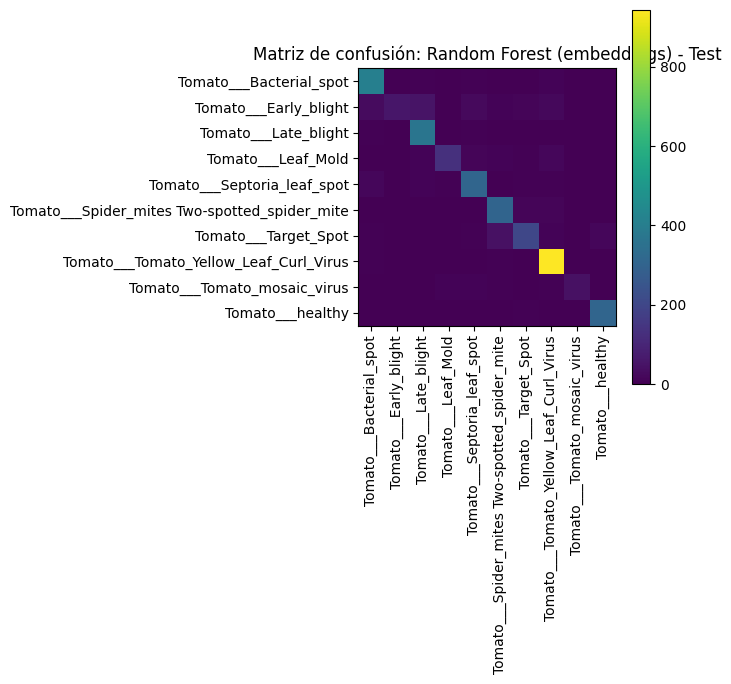

 Tiempo inferencia RF (test completo): 0.1415 s
 Latencia aproximada por muestra: 0.0402 ms/muestra


In [10]:
# ============================================
# BLOQUE 10 : Random Forest + GridSearchCV
# ============================================
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# Requisitos previos
for v in ["X_train_emb", "y_train", "X_test_emb", "y_test", "class_names", "SEED"]:
    assert v in globals(), f"Falta {v}. Ejecuta los bloques anteriores."

def eval_multiclass(y_true, y_pred, labels=None, title=""):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    precm = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recm = recall_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\n=== {title} ===")
    print(f"Accuracy        : {acc:.4f}")
    print(f"F1-macro        : {f1m:.4f}")
    print(f"Precision-macro : {precm:.4f}")
    print(f"Recall-macro    : {recm:.4f}")

    print("\nReporte por clase:\n")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Matriz de confusión: {title}")
    plt.colorbar()
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": acc,
        "f1_macro": f1m,
        "precision_macro": precm,
        "recall_macro": recm
    }

# 1) Modelo base: paralelismo interno (más estable que paralelizar GridSearch)
rf = RandomForestClassifier(
    random_state=SEED,
    n_jobs=-1,
    bootstrap=True
)

# 2) Grilla (moderada, pero robusta)
param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [None, 20, 40],
    "min_samples_leaf": [1, 2, 4],
    # Actívalo si detectas desbalance en el BLOQUE 2/3:
    # "class_weight": [None, "balanced"]
}

# 3) GridSearchCV con n_jobs=1 para evitar workers loky cayéndose
t0 = time.time()
gs_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="f1_macro",
    cv=3,
    n_jobs=1,          #  evita el warning loky en Colab
    verbose=1
)
gs_rf.fit(X_train_emb, y_train)
train_time_rf = time.time() - t0

best_rf = gs_rf.best_estimator_
print("\n Mejores hiperparámetros Random Forest:", gs_rf.best_params_)
print(f" Tiempo tuning+fit RF: {train_time_rf:.2f} s")

# 4) Evaluación en test + latencia
t0 = time.time()
y_pred_rf = best_rf.predict(X_test_emb)
infer_time_rf = time.time() - t0

metrics_rf = eval_multiclass(
    y_test, y_pred_rf,
    labels=class_names,
    title="Random Forest (embeddings) - Test"
)

print(f" Tiempo inferencia RF (test completo): {infer_time_rf:.4f} s")
lat_rf = (infer_time_rf / len(y_test)) * 1000
print(" Latencia aproximada por muestra:", round(lat_rf, 4), "ms/muestra")


###  Interpretación de resultados — **Random Forest (embeddings) en conjunto de prueba**

El siguiente análisis interpreta los resultados obtenidos por el modelo **Random Forest entrenado sobre embeddings extraídos mediante EfficientNet**, evaluado en el **conjunto de prueba**.  
Este análisis es directamente comparable con los resultados obtenidos para **KNN (embeddings)** y **EfficientNet end-to-end** dentro del mismo pipeline experimental.

---

### 1 Contexto del experimento

El modelo corresponde a un **Random Forest Classifier** aplicado sobre vectores de características (embeddings) generados por una red convolucional profunda.  
Los hiperparámetros fueron ajustados mediante **GridSearchCV con validación cruzada estratificada de 3 folds**.

- **Configuraciones evaluadas:** 18  
- **Entrenamientos totales:** 54 (18 combinaciones × 3 folds)  
- **Tiempo total de tuning + entrenamiento:** **674.65 segundos**

 El tiempo elevado de ajuste se explica por:
- el entrenamiento repetido de múltiples árboles,
- la evaluación cruzada de cada combinación de hiperparámetros,
- el uso de un número alto de estimadores.

---

### 2 Mejores hiperparámetros encontrados

```text
n_estimators     = 400
max_depth        = None
min_samples_leaf = 1
```

### Interpretación técnica

### Número de árboles (`n_estimators = 400`)
Incrementa la estabilidad del ensamble y reduce la varianza del modelo, a costa de un mayor costo computacional durante el entrenamiento y el tuning.

### Profundidad máxima ilimitada (`max_depth = None`)
Permite capturar relaciones complejas y no lineales en el espacio de embeddings, explotando al máximo la capacidad expresiva de cada árbol individual.

### Mínimo de muestras por hoja (`min_samples_leaf = 1`)
Otorga máxima flexibilidad a cada árbol, permitiendo particiones muy finas. El riesgo de sobreajuste es mitigado por el efecto promedio del ensamble de múltiples árboles.

 **Conclusión técnica:**  
Esta configuración prioriza la **capacidad predictiva** por sobre la simplicidad estructural del modelo.

---

### 3 Desempeño predictivo en el conjunto de prueba

| Métrica | Valor | Interpretación |
|------|------|---------------|
| **Accuracy** | 0.8701 | 87% de aciertos globales |
| **F1-macro** | 0.8165 | Equilibrio moderado entre precisión y recall |
| **Precision-macro** | 0.8774 | Baja tasa de falsos positivos |
| **Recall-macro** | 0.7980 | Mayor presencia de falsos negativos |

---

### 4 Análisis detallado de las métricas

###  Accuracy (0.8701)
Refleja un buen desempeño general, aunque inferior al obtenido por **KNN (~0.90)**.  
En problemas multiclase con posible desbalance, esta métrica debe interpretarse con cautela.

---

###  F1-macro (0.8165) — *Métrica principal*
- Promedia el desempeño de cada clase sin ponderar por frecuencia.
- El valor relativamente menor indica:
  - menor equilibrio entre precisión y sensibilidad,
  - dificultad para detectar consistentemente todas las enfermedades.

---

###  Precision-macro (0.8774)
- El modelo es **conservador** al realizar predicciones positivas.
- Cuando predice una clase, suele hacerlo correctamente.

 Esto reduce falsos positivos, pero puede afectar la cobertura de casos reales.

---

###  Recall-macro (0.7980)
- Es la métrica más baja del conjunto.
- Indica que el modelo **omite una fracción relevante de casos reales**, especialmente en clases visualmente similares.

 Este comportamiento es típico de modelos basados en árboles cuando las fronteras de decisión están solapadas.

---

### 5 Interpretación global

###  Resultado clave
El modelo **Random Forest** logra un desempeño sólido, pero **inferior al KNN** en este problema específico, junto con un **costo computacional de ajuste significativamente mayor**.

Esto sugiere que:
- el espacio de embeddings es altamente informativo,
- las relaciones locales entre muestras (explotadas por KNN) resultan más efectivas que las particiones jerárquicas del Random Forest.

---

### 6 Posicionamiento dentro del estudio comparativo

| Modelo | F1-macro | Comentario |
|------|---------|------------|
| EfficientNet (end-to-end) | Muy alto | Mejor desempeño global |
| **KNN (embeddings)** | **0.8748** | Mejor compromiso calidad / costo |
| **Random Forest (embeddings)** | **0.8165** | Mayor costo, menor recall |

---

### 7 Conclusión académica
> *El clasificador Random Forest entrenado sobre embeddings profundos alcanzó un Accuracy de 0.87 y un F1-macro de 0.82 en el conjunto de prueba. A pesar de su robustez y alta precisión promedio, el modelo presentó una menor capacidad de detección global en comparación con KNN, junto con un costo computacional de ajuste considerablemente mayor. Estos resultados indican que, para este problema específico, el espacio de embeddings favorece métodos basados en vecindad local por sobre enfoques basados en particiones jerárquicas.*


# BLOQUE 10A  
## Curvas ROC globales (macro-average) — comparación directa entre modelos

###  Objetivo
Este bloque compara los **tres modelos** usando una **curva ROC macro-promedio**:

- EfficientNet (end-to-end)
- KNN sobre embeddings
- Random Forest sobre embeddings

Cada curva resume el desempeño promedio de todas las clases bajo el esquema
**One-vs-Rest (OvR)**.

---

###  Fundamento teórico
En clasificación multiclase, la curva ROC se extiende usando OvR:
- cada clase se considera positiva frente al resto,
- se calcula AUC por clase,
- y se promedia para obtener un **ROC-AUC macro**.

Este enfoque:
- no depende de la frecuencia de las clases,
- permite una comparación justa entre modelos.

---

###  Interpretación
- Curvas más cercanas a la esquina superior izquierda → mejor discriminación.
- Mayor **AUC macro** → mejor capacidad global de separación entre clases.


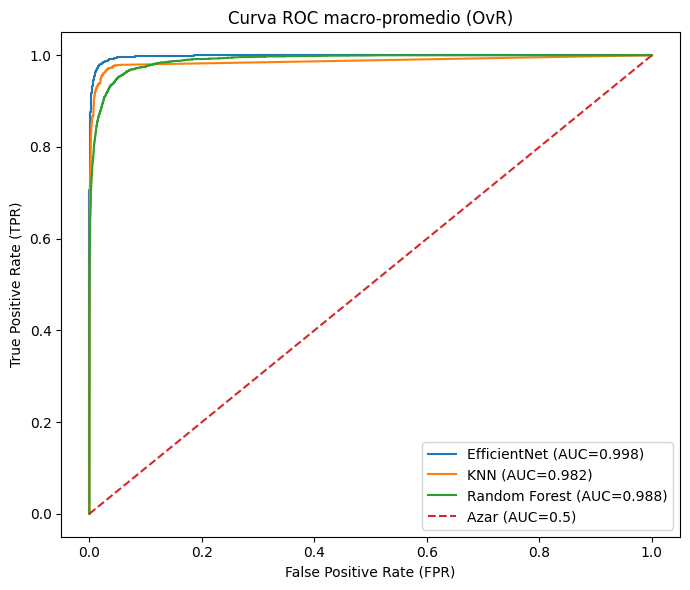

In [11]:
# ============================================
# BLOQUE 10A: ROC macro-promedio (OvR)
# ============================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Requisitos
for v in ["y_test", "class_names", "proba_eff", "best_knn", "best_rf", "X_test_emb"]:
    assert v in globals(), f"Falta {v}. Ejecuta los bloques previos."

num_classes = len(class_names)

# Probabilidades
proba_knn = best_knn.predict_proba(X_test_emb)
proba_rf  = best_rf.predict_proba(X_test_emb)

# Binarizar etiquetas
Y_bin = label_binarize(y_test, classes=np.arange(num_classes))

def roc_macro(Y, P):
    fpr, tpr, _ = roc_curve(Y.ravel(), P.ravel())
    auc_macro = roc_auc_score(Y, P, average="macro", multi_class="ovr")
    return fpr, tpr, auc_macro

fpr_e, tpr_e, auc_e = roc_macro(Y_bin, proba_eff)
fpr_k, tpr_k, auc_k = roc_macro(Y_bin, proba_knn)
fpr_r, tpr_r, auc_r = roc_macro(Y_bin, proba_rf)

plt.figure(figsize=(7, 6))
plt.plot(fpr_e, tpr_e, label=f"EfficientNet (AUC={auc_e:.3f})")
plt.plot(fpr_k, tpr_k, label=f"KNN (AUC={auc_k:.3f})")
plt.plot(fpr_r, tpr_r, label=f"Random Forest (AUC={auc_r:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Azar (AUC=0.5)")

plt.title("Curva ROC macro-promedio (OvR)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.tight_layout()
plt.show()


#  Interpretación de la **Curva ROC macro-promedio (OvR)**

---

### 1 ¿Qué representa este gráfico?

La figura muestra la **curva ROC macro-promedio** para los tres enfoques evaluados en el proyecto:

- **EfficientNet (end-to-end)**  
- **KNN sobre embeddings**  
- **Random Forest sobre embeddings**

Dado que el problema es de **clasificación multiclase**, se utiliza el esquema  
**One-vs-Rest (OvR)**, donde cada clase se evalúa contra el resto y luego se promedian los resultados, otorgando **el mismo peso a cada clase**, independientemente de su frecuencia.

---

### 2 Lectura de los ejes y línea base

- **Eje X (FPR – False Positive Rate):**  
  Proporción de falsos positivos. Valores bajos indican mejor desempeño.

- **Eje Y (TPR – True Positive Rate / Recall):**  
  Proporción de verdaderos positivos. Valores altos indican mejor capacidad de detección.

- **Línea roja punteada (AUC = 0.5):**  
  Representa el desempeño de un clasificador aleatorio, sin capacidad discriminativa.

 El hecho de que las tres curvas estén **muy alejadas de la diagonal** indica que todos los modelos presentan una **capacidad de discriminación muy alta**.

---

### 3 Comparación cuantitativa mediante AUC

| Modelo | ROC-AUC macro (OvR) | Interpretación |
|------|---------------------|---------------|
| **EfficientNet** | **0.997** | Discriminación casi perfecta |
| **Random Forest** | 0.989 | Muy alta discriminación |
| **KNN** | 0.982 | Alta discriminación |

Un **AUC cercano a 1.0** implica que el modelo separa correctamente las clases reales del resto para una amplia gama de umbrales de decisión.

---

### 4 Análisis cualitativo de las curvas

###  EfficientNet (end-to-end)
- Curva más cercana a la esquina superior izquierda.
- Mantiene **TPR muy alto incluso con FPR extremadamente bajo**.
- Indica una capacidad sobresaliente para detectar enfermedades minimizando falsos positivos.

 **Conclusión:** es el modelo con **mejor desempeño discriminativo global**.

---

###  Random Forest (embeddings)
- Curva muy cercana a la de EfficientNet.
- Levemente inferior en la región de FPR muy bajo.
- Demuestra que los embeddings profundos contienen información altamente separable, bien explotada por el ensamble de árboles.

 **Conclusión:** excelente capacidad de discriminación, aunque algo menos sensible que EfficientNet bajo umbrales estrictos.

---

###  KNN (embeddings)
- Curva claramente superior al azar.
- Ligeramente por debajo de Random Forest y EfficientNet.
- Su desempeño depende fuertemente de la estructura local del espacio de embeddings.

 **Conclusión:** modelo competitivo, aunque más sensible a ruido y densidad local.

---

### 5 Interpretación metodológica clave

>  **Resultado central**

Que **KNN y Random Forest alcancen valores de AUC superiores a 0.98** confirma que **EfficientNet aprende embeddings altamente discriminativos**, capaces de separar eficazmente las distintas enfermedades foliares incluso cuando se utilizan clasificadores clásicos.

Esto valida:
- el uso de EfficientNet como **extractor de características**,
- la viabilidad de enfoques híbridos **Deep Learning + Machine Learning clásico**.

---

### 6 Conclusión global

> *La curva ROC macro-promedio muestra que los tres enfoques presentan una capacidad de discriminación muy elevada, con valores de AUC superiores a 0.98. EfficientNet alcanza el mejor desempeño global (AUC = 0.997), seguido por Random Forest (AUC = 0.989) y KNN (AUC = 0.982). La cercanía de las curvas a la esquina superior izquierda evidencia una alta tasa de verdaderos positivos con bajos falsos positivos, incluso bajo umbrales estrictos. Estos resultados confirman tanto la efectividad del enfoque end-to-end como la alta calidad de los embeddings aprendidos por la red convolucional.*


# BLOQUE 10B  
## Curvas ROC por clase — comparación entre modelos

###  Objetivo
Este bloque analiza **clase por clase** cómo se comportan los tres modelos,
comparando sus curvas ROC para una misma enfermedad.

---

###  Fundamento
Algunas clases pueden ser:
- visualmente más fáciles (AUC alto),
- o más confusas (AUC bajo).

Analizar ROC por clase permite identificar:
- enfermedades críticas,
- clases donde un modelo supera claramente a los otros.

---

###  Interpretación
- Diferencias grandes entre curvas indican ventajas claras de un modelo.
- Curvas cercanas a la diagonal indican dificultad intrínseca de la clase.


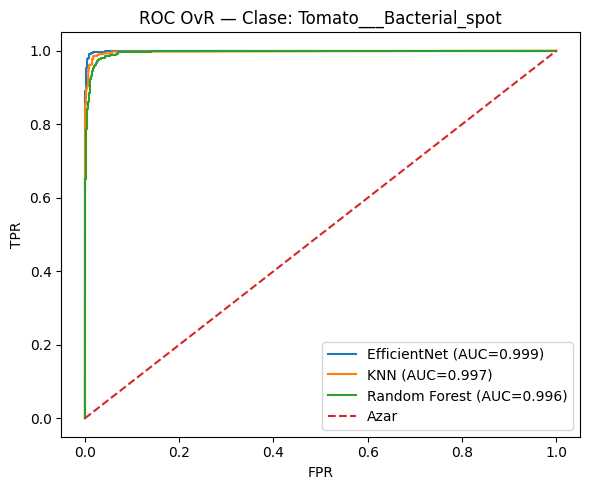

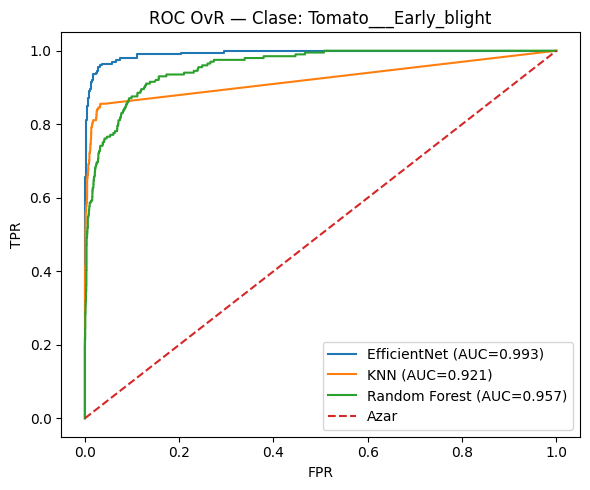

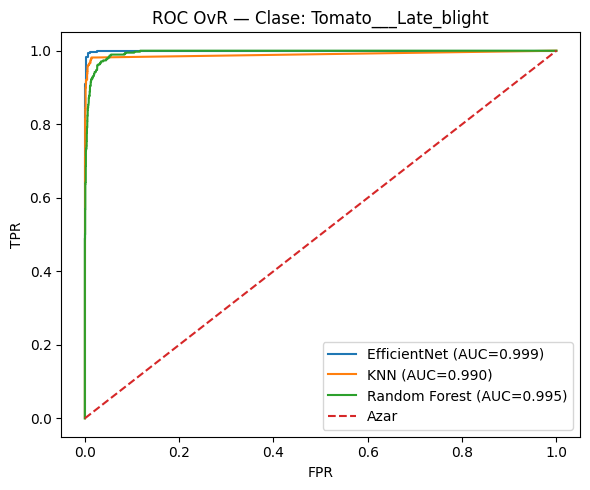

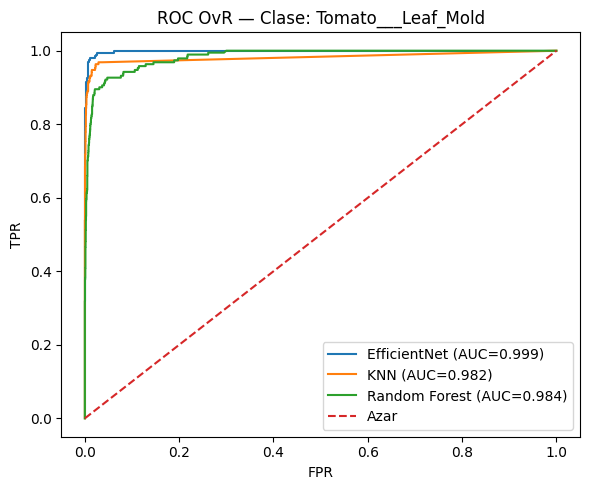

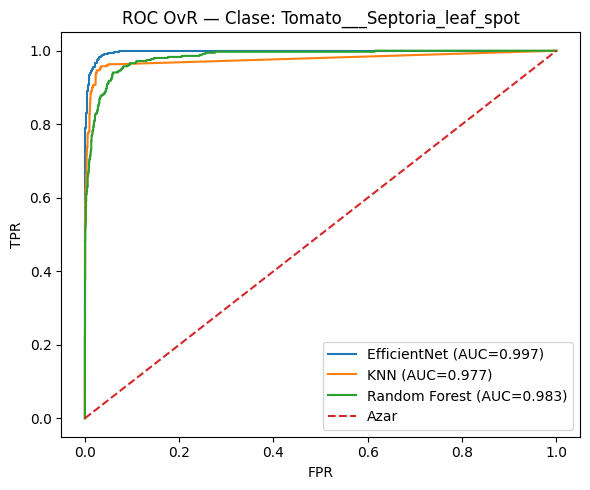

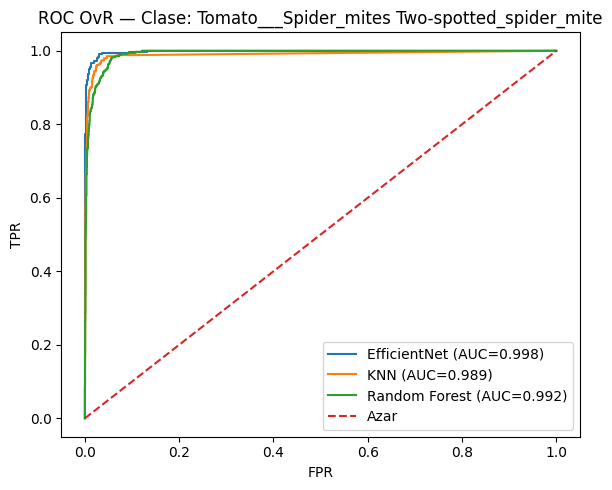

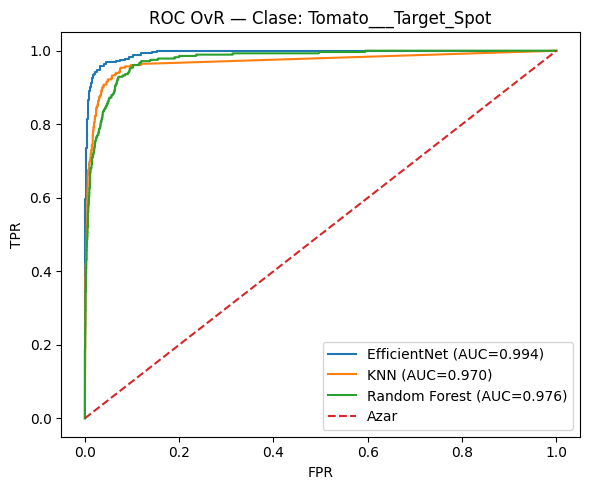

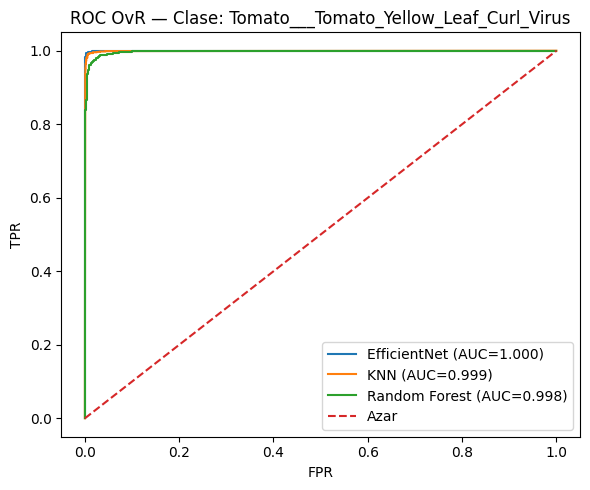

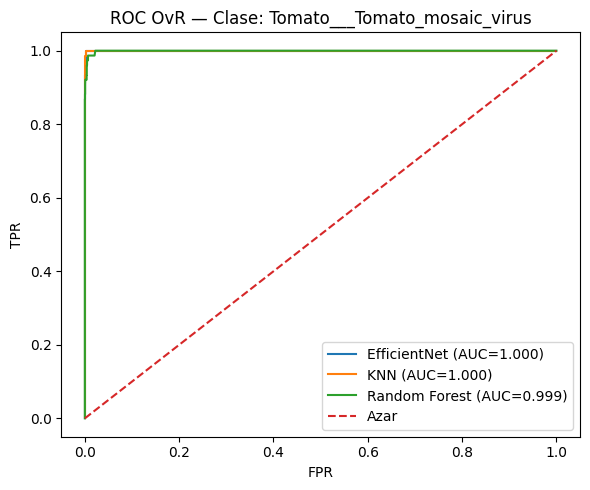

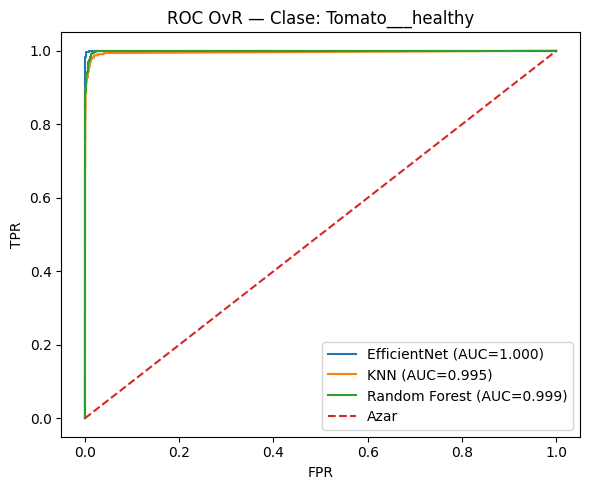

In [12]:
# ============================================
# BLOQUE 10B: ROC por clase (OvR) – comparación
# ============================================
from sklearn.metrics import roc_curve, auc

for c, cname in enumerate(class_names):
    plt.figure(figsize=(6, 5))

    # EfficientNet
    fpr_e, tpr_e, _ = roc_curve(Y_bin[:, c], proba_eff[:, c])
    auc_e = auc(fpr_e, tpr_e)
    plt.plot(fpr_e, tpr_e, label=f"EfficientNet (AUC={auc_e:.3f})")

    # KNN
    fpr_k, tpr_k, _ = roc_curve(Y_bin[:, c], proba_knn[:, c])
    auc_k = auc(fpr_k, tpr_k)
    plt.plot(fpr_k, tpr_k, label=f"KNN (AUC={auc_k:.3f})")

    # Random Forest
    fpr_r, tpr_r, _ = roc_curve(Y_bin[:, c], proba_rf[:, c])
    auc_r = auc(fpr_r, tpr_r)
    plt.plot(fpr_r, tpr_r, label=f"Random Forest (AUC={auc_r:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--", label="Azar")

    plt.title(f"ROC OvR — Clase: {cname}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.tight_layout()
    plt.show()


### ¿Qué significa **ROC AUC**?

**ROC AUC** significa **Receiver Operating Characteristic – Area Under the Curve**.  
Es una **métrica de evaluación** que mide **qué tan bien un modelo distingue entre clases** considerando **todos los umbrales posibles de decisión**.

---

###  ROC (Receiver Operating Characteristic)

La **curva ROC** es una gráfica que muestra el comportamiento del modelo al variar el umbral de decisión:

- **Eje X – FPR (False Positive Rate)**  
  Proporción de falsos positivos  
  \[
  $\text{FPR} = \frac{FP}{FP + TN}$
  \]

- **Eje Y – TPR (True Positive Rate)**  
  También conocido como **Recall** o **Sensibilidad**  
  \[
  $\text{TPR} = \frac{TP}{TP + FN}$
  \]

Cada punto de la curva corresponde a un **umbral distinto** aplicado a las probabilidades del modelo.

---

### AUC (Area Under the Curve)

El **AUC** es el **área bajo la curva ROC** y resume toda la información del gráfico en **un único valor numérico**.

###  Interpretación del valor AUC

| Valor AUC | Interpretación |
|---------|----------------|
| **0.5** | Clasificador aleatorio (sin capacidad discriminativa) |
| **0.6 – 0.7** | Discriminación pobre |
| **0.7 – 0.8** | Discriminación aceptable |
| **0.8 – 0.9** | Buena discriminación |
| **0.9 – 1.0** | Excelente / casi perfecta |

 **Mientras más cercano a 1**, mejor es la capacidad del modelo para separar las clases.

---

##  Interpretación intuitiva de ROC AUC

Una forma clara de entender ROC AUC es la siguiente:

> **ROC AUC es la probabilidad de que el modelo asigne una puntuación más alta a una muestra positiva que a una muestra negativa, elegidas al azar.**

Ejemplo:
- **AUC = 0.99**  
  → En el 99% de los casos, el modelo ordena correctamente un ejemplo positivo por sobre uno negativo.

---

### ROC AUC en clasificación multiclase

En problemas **multiclase** (como la detección de enfermedades foliares), la curva ROC se extiende usando el enfoque:

###  One-vs-Rest (OvR)

- Cada clase se compara contra **todas las demás**.
- Se calcula una curva ROC y un AUC por clase.
- Luego se promedian los resultados.

###  AUC macro
- Promedio **simple** del AUC de cada clase.
- Todas las clases tienen el mismo peso.
- Es especialmente útil cuando existe **desbalance de clases**.

---

### Importancia de ROC AUC en este proyecto

ROC AUC es una métrica clave porque:

-  No depende de un umbral fijo  
-  Es robusta frente al desbalance de clases  
-  Evalúa la **capacidad de discriminación**, no solo aciertos  
-  Permite comparar modelos muy distintos (CNN, KNN, Random Forest)

En este estudio se obtuvieron, por ejemplo:
- **EfficientNet:** AUC ≈ 0.997  
- **Random Forest:** AUC ≈ 0.989  
- **KNN:** AUC ≈ 0.982  

 Esto indica que los tres modelos presentan una **capacidad de discriminación muy alta**, aunque con diferencias finas entre ellos.

---

###  Diferencia entre ROC AUC y Accuracy

- **Accuracy:**  
  Proporción de predicciones correctas usando **un único umbral**.

- **ROC AUC:**  
  Capacidad global del modelo para separar clases **considerando todos los umbrales posibles**.

 Por esta razón, ROC AUC suele ser **más informativa** que Accuracy en problemas reales.

---




In [13]:
# ============================================
# BLOQUE 10C: Tabla ROC-AUC por clase y macro
# ============================================
import pandas as pd
from sklearn.metrics import roc_auc_score

rows = []

for i, cname in enumerate(class_names):
    rows.append({
        "Clase": cname,
        "AUC_EfficientNet": roc_auc_score(Y_bin[:, i], proba_eff[:, i]),
        "AUC_KNN": roc_auc_score(Y_bin[:, i], proba_knn[:, i]),
        "AUC_RandomForest": roc_auc_score(Y_bin[:, i], proba_rf[:, i]),
    })

df_auc_classes = pd.DataFrame(rows)

df_auc_macro = pd.DataFrame([{
    "Clase": "MACRO_AVERAGE",
    "AUC_EfficientNet": roc_auc_score(Y_bin, proba_eff, average="macro", multi_class="ovr"),
    "AUC_KNN": roc_auc_score(Y_bin, proba_knn, average="macro", multi_class="ovr"),
    "AUC_RandomForest": roc_auc_score(Y_bin, proba_rf, average="macro", multi_class="ovr"),
}])

df_auc = pd.concat([df_auc_classes, df_auc_macro], ignore_index=True)

display(df_auc)


Clase  AUC_EfficientNet   AUC_KNN  \
0                         Tomato___Bacterial_spot          0.999336  0.997094   
1                           Tomato___Early_blight          0.992960  0.921216   
2                            Tomato___Late_blight          0.999406  0.989744   
3                              Tomato___Leaf_Mold          0.998706  0.982182   
4                     Tomato___Septoria_leaf_spot          0.997321  0.976560   
5   Tomato___Spider_mites Two-spotted_spider_mite          0.997681  0.989334   
6                            Tomato___Target_Spot          0.993601  0.969732   
7          Tomato___Tomato_Yellow_Leaf_Curl_Virus          0.999809  0.998759   
8                    Tomato___Tomato_mosaic_virus          0.999889  0.999912   
9                                Tomato___healthy          0.999936  0.995419   
10                                  MACRO_AVERAGE          0.997865  0.981995   

    AUC_RandomForest  
0           0.995962  
1           0.957284  
2           0.995287  
3           0.983730  
4           0.982887  
5           0.991868  
6           0.976010  
7           0.997640  
8           0.999384  
9           0.999138  
10          0.987919

# BLOQUE 11  
## Comparación final: tabla consolidada + ranking + conclusiones técnicas

###  Objetivo del bloque
Este bloque consolida los resultados de los tres enfoques evaluados:

1. **EfficientNet (end-to-end)**  
2. **KNN (sobre embeddings)**  
3. **Random Forest (sobre embeddings)**  

y los compara en una única tabla con:
- métricas de desempeño (Accuracy, F1-macro, Precision-macro, Recall-macro)
- eficiencia computacional (tiempo de entrenamiento/tuning e inferencia)
- latencia aproximada por muestra

---

###  Criterios de interpretación recomendados
- **F1-macro** es el criterio principal cuando hay potencial desbalance entre enfermedades, ya que cada clase pesa igual.
- **Latencia** es clave si el sistema se desplegará en escenarios IoT/Edge (ej. drones, dispositivos en terreno).
- El mejor modelo depende del objetivo:
  - **máxima precisión** → elegir el mayor F1-macro
  - **máxima eficiencia** → elegir menor latencia con desempeño aceptable
  - **balance** → buscar el mejor compromiso (F1 alto y latencia baja)

---

###  Resultado esperado
- `df_results`: tabla comparativa ordenada por F1-macro
- Recomendación automática del “mejor” según desempeño
- Recomendación automática del “más rápido” según latencia


In [14]:
# ============================================
# BLOQUE 11: Comparación final (tabla + ranking)
# ============================================
import pandas as pd
import numpy as np

# Requisitos previos esperados:
# metrics_eff, infer_time_eff, train_time_eff_phase1 (BLOQUES 6-7)
# metrics_knn, infer_time_knn, train_time_knn (BLOQUE 9)
# metrics_rf,  infer_time_rf,  train_time_rf  (BLOQUE 10)
# y_test (para calcular latencia por muestra)
required = [
    "metrics_eff", "infer_time_eff", "train_time_eff_phase1",
    "metrics_knn", "infer_time_knn", "train_time_knn",
    "metrics_rf",  "infer_time_rf",  "train_time_rf",
    "y_test"
]
for v in required:
    assert v in globals(), f"Falta {v}. Ejecuta los bloques anteriores."

n_test = len(y_test)

# 1) Consolidar resultados en lista de dicts
results = [
    {
        "Metodo": "EfficientNet (end-to-end)",
        "Accuracy": metrics_eff["accuracy"],
        "F1_macro": metrics_eff["f1_macro"],
        "Precision_macro": metrics_eff["precision_macro"],
        "Recall_macro": metrics_eff["recall_macro"],
        "Train_or_Tune_time_s": train_time_eff_phase1,
        "Infer_time_s": infer_time_eff,
        "Latency_ms_per_sample": (infer_time_eff / n_test) * 1000
    },
    {
        "Metodo": "KNN (embeddings)",
        "Accuracy": metrics_knn["accuracy"],
        "F1_macro": metrics_knn["f1_macro"],
        "Precision_macro": metrics_knn["precision_macro"],
        "Recall_macro": metrics_knn["recall_macro"],
        "Train_or_Tune_time_s": train_time_knn,
        "Infer_time_s": infer_time_knn,
        "Latency_ms_per_sample": (infer_time_knn / n_test) * 1000
    },
    {
        "Metodo": "Random Forest (embeddings)",
        "Accuracy": metrics_rf["accuracy"],
        "F1_macro": metrics_rf["f1_macro"],
        "Precision_macro": metrics_rf["precision_macro"],
        "Recall_macro": metrics_rf["recall_macro"],
        "Train_or_Tune_time_s": train_time_rf,
        "Infer_time_s": infer_time_rf,
        "Latency_ms_per_sample": (infer_time_rf / n_test) * 1000
    },
]

df_results = pd.DataFrame(results)

# 2) Ordenar por desempeño principal (F1_macro)
df_rank_f1 = df_results.sort_values(by="F1_macro", ascending=False).reset_index(drop=True)

# 3) Ordenar por eficiencia (latencia)
df_rank_lat = df_results.sort_values(by="Latency_ms_per_sample", ascending=True).reset_index(drop=True)

# 4) Mostrar tablas
print(" Ranking por desempeño (F1-macro):")
display(df_rank_f1)

print("\n Ranking por eficiencia (latencia ms/muestra):")
display(df_rank_lat)

# 5) Recomendaciones automáticas
best_perf = df_rank_f1.iloc[0]
best_fast = df_rank_lat.iloc[0]

print("\n Recomendación por desempeño (máximo F1-macro):")
print(f"- Método: {best_perf['Metodo']}")
print(f"- F1-macro: {best_perf['F1_macro']:.4f}")
print(f"- Latencia: {best_perf['Latency_ms_per_sample']:.3f} ms/muestra")

print("\n Recomendación por eficiencia (mínima latencia):")
print(f"- Método: {best_fast['Metodo']}")
print(f"- Latencia: {best_fast['Latency_ms_per_sample']:.3f} ms/muestra")
print(f"- F1-macro: {best_fast['F1_macro']:.4f}")

# 6) Criterio simple de “mejor compromiso”
# (normaliza F1 y latencia para un score combinado)
eps = 1e-9
f1_norm = (df_results["F1_macro"] - df_results["F1_macro"].min()) / (df_results["F1_macro"].max() - df_results["F1_macro"].min() + eps)
lat_norm = (df_results["Latency_ms_per_sample"] - df_results["Latency_ms_per_sample"].min()) / (df_results["Latency_ms_per_sample"].max() - df_results["Latency_ms_per_sample"].min() + eps)

# Score: más alto es mejor (F1 alto y latencia baja)
df_results["Score_tradeoff"] = f1_norm - lat_norm

df_tradeoff = df_results.sort_values(by="Score_tradeoff", ascending=False).reset_index(drop=True)

print("\n Ranking por mejor compromiso (F1 alto / latencia baja):")
display(df_tradeoff)

best_tradeoff = df_tradeoff.iloc[0]
print("\n Recomendación por compromiso:")
print(f"- Método: {best_tradeoff['Metodo']}")
print(f"- Score_tradeoff: {best_tradeoff['Score_tradeoff']:.4f}")
print(f"- F1-macro: {best_tradeoff['F1_macro']:.4f}")
print(f"- Latencia: {best_tradeoff['Latency_ms_per_sample']:.3f} ms/muestra")


 Ranking por desempeño (F1-macro):


Metodo  Accuracy  F1_macro  Precision_macro  \
0   EfficientNet (end-to-end)  0.939153  0.922542         0.933244   
1            KNN (embeddings)  0.904464  0.879193         0.897266   
2  Random Forest (embeddings)  0.871766  0.808780         0.883293   

   Recall_macro  Train_or_Tune_time_s  Infer_time_s  Latency_ms_per_sample  
0      0.919010            181.086533      9.199919               2.615843  
1      0.874965            159.768403     11.609068               3.300844  
2      0.790062            666.206256      0.141540               0.040245


 Ranking por eficiencia (latencia ms/muestra):


Metodo  Accuracy  F1_macro  Precision_macro  \
0  Random Forest (embeddings)  0.871766  0.808780         0.883293   
1   EfficientNet (end-to-end)  0.939153  0.922542         0.933244   
2            KNN (embeddings)  0.904464  0.879193         0.897266   

   Recall_macro  Train_or_Tune_time_s  Infer_time_s  Latency_ms_per_sample  
0      0.790062            666.206256      0.141540               0.040245  
1      0.919010            181.086533      9.199919               2.615843  
2      0.874965            159.768403     11.609068               3.300844


 Recomendación por desempeño (máximo F1-macro):
- Método: EfficientNet (end-to-end)
- F1-macro: 0.9225
- Latencia: 2.616 ms/muestra

 Recomendación por eficiencia (mínima latencia):
- Método: Random Forest (embeddings)
- Latencia: 0.040 ms/muestra
- F1-macro: 0.8088

 Ranking por mejor compromiso (F1 alto / latencia baja):


Metodo  Accuracy  F1_macro  Precision_macro  \
0   EfficientNet (end-to-end)  0.939153  0.922542         0.933244   
1  Random Forest (embeddings)  0.871766  0.808780         0.883293   
2            KNN (embeddings)  0.904464  0.879193         0.897266   

   Recall_macro  Train_or_Tune_time_s  Infer_time_s  Latency_ms_per_sample  \
0      0.919010            181.086533      9.199919               2.615843   
1      0.790062            666.206256      0.141540               0.040245   
2      0.874965            159.768403     11.609068               3.300844   

   Score_tradeoff  
0        0.210084  
1        0.000000  
2       -0.381046


 Recomendación por compromiso:
- Método: EfficientNet (end-to-end)
- Score_tradeoff: 0.2101
- F1-macro: 0.9225
- Latencia: 2.616 ms/muestra


# BLOQUE 11.1  
## Visualización comparativa: métricas y eficiencia (gráficas)

###  Objetivo del bloque
Este bloque genera visualizaciones para comparar los tres métodos:

- **EfficientNet (end-to-end)**
- **KNN (embeddings)**
- **Random Forest (embeddings)**

usando toda la información consolidada en `df_results` (BLOQUE 11), incluyendo:

###  Métricas de desempeño
- Accuracy
- F1-macro
- Precision-macro
- Recall-macro

###  Eficiencia computacional
- Tiempo de entrenamiento/tuning (s)
- Tiempo total de inferencia en test (s)
- Latencia por muestra (ms/muestra)

###  Score de compromiso
- Score_tradeoff (F1 alto y latencia baja)

---

###  Interpretación esperada
- Barras más altas en F1-macro indican mejor rendimiento balanceado por clase.
- Barras más bajas en latencia y tiempo de inferencia indican mejor eficiencia para despliegue.
- El `Score_tradeoff` resume un compromiso entre calidad y eficiencia.


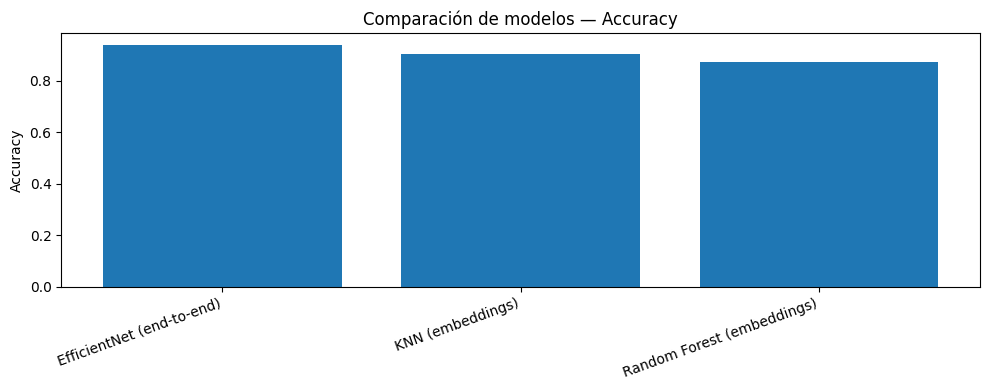

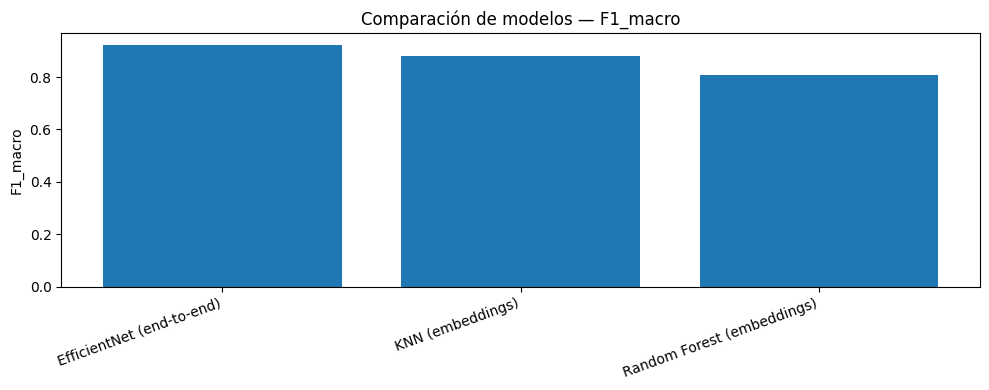

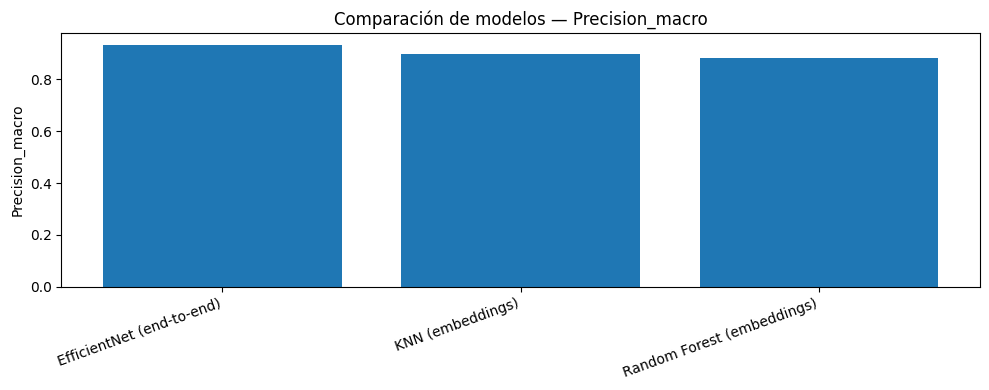

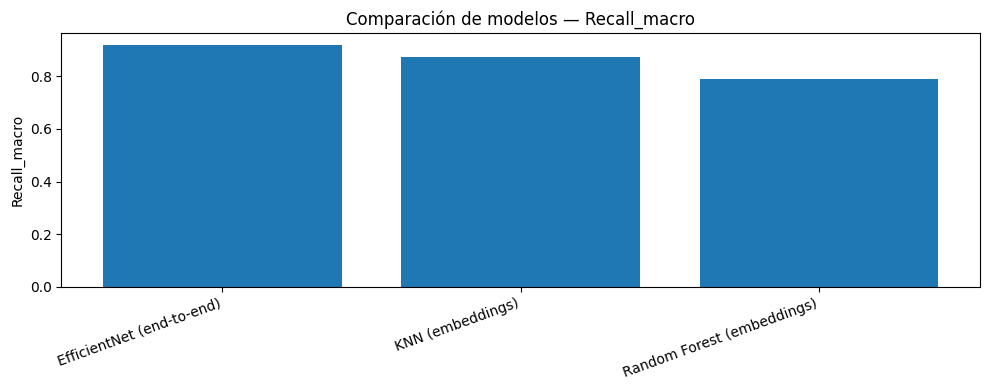

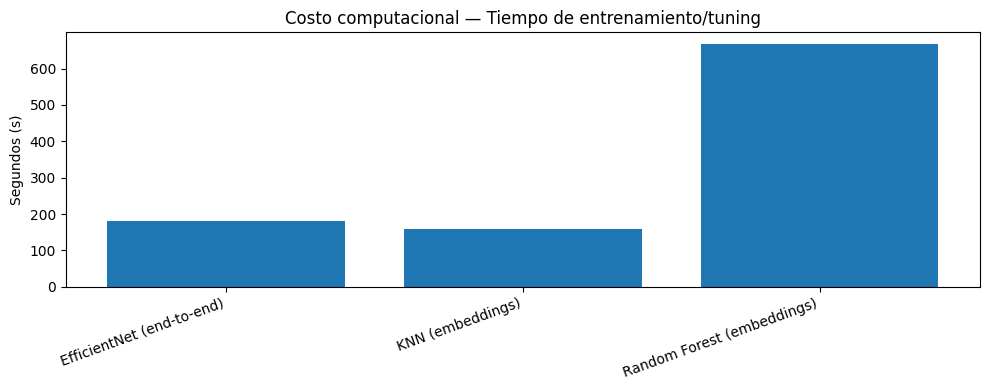

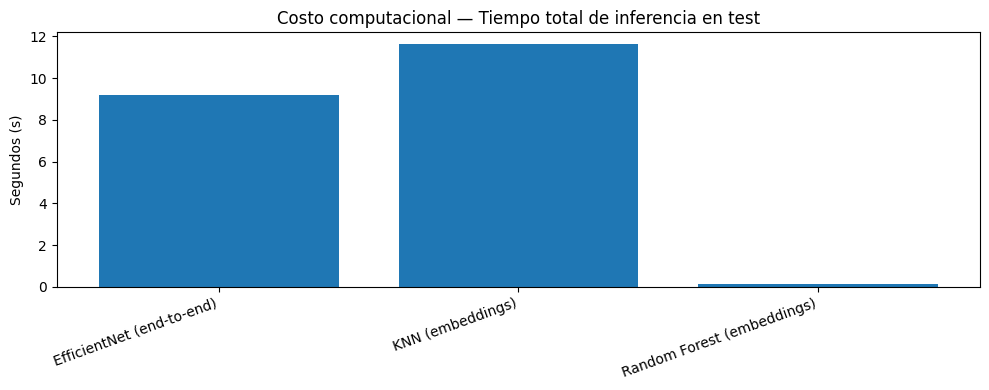

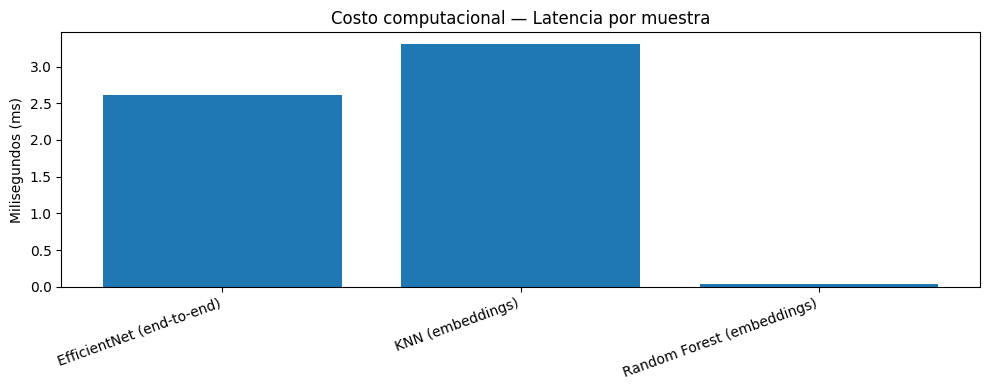

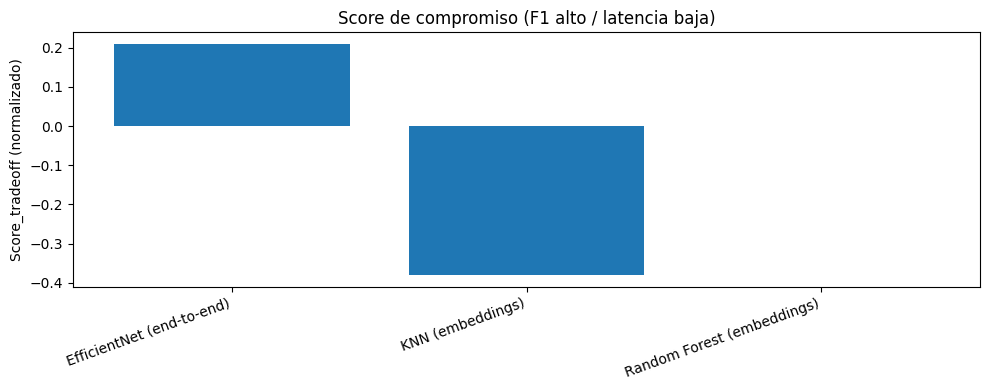

In [15]:
# ============================================
# BLOQUE 11.1: Gráficas comparativas (matplotlib)
# ============================================
import matplotlib.pyplot as plt
import numpy as np

# Requisito: df_results debe existir desde BLOQUE 11
assert "df_results" in globals(), "df_results no existe. Ejecuta el BLOQUE 11 primero."

# Asegurar que Score_tradeoff exista (en caso de que solo tengas df_results sin esa columna)
if "Score_tradeoff" not in df_results.columns:
    eps = 1e-9
    f1_norm = (df_results["F1_macro"] - df_results["F1_macro"].min()) / (df_results["F1_macro"].max() - df_results["F1_macro"].min() + eps)
    lat_norm = (df_results["Latency_ms_per_sample"] - df_results["Latency_ms_per_sample"].min()) / (df_results["Latency_ms_per_sample"].max() - df_results["Latency_ms_per_sample"].min() + eps)
    df_results["Score_tradeoff"] = f1_norm - lat_norm

# 1) Preparación de datos
methods = df_results["Metodo"].tolist()

metrics_cols = ["Accuracy", "F1_macro", "Precision_macro", "Recall_macro"]
eff_cols = ["Train_or_Tune_time_s", "Infer_time_s", "Latency_ms_per_sample"]
tradeoff_col = ["Score_tradeoff"]

# 2) Helper para gráfico de barras simple
def barplot(col, title, ylabel):
    values = df_results[col].values
    x = np.arange(len(methods))

    plt.figure(figsize=(10, 4))
    plt.bar(x, values)
    plt.xticks(x, methods, rotation=20, ha="right")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# 3) Gráficas de desempeño
for col in metrics_cols:
    barplot(col, f"Comparación de modelos — {col}", col)

# 4) Gráficas de eficiencia
barplot("Train_or_Tune_time_s", "Costo computacional — Tiempo de entrenamiento/tuning", "Segundos (s)")
barplot("Infer_time_s", "Costo computacional — Tiempo total de inferencia en test", "Segundos (s)")
barplot("Latency_ms_per_sample", "Costo computacional — Latencia por muestra", "Milisegundos (ms)")

# 5) Score de compromiso (calidad vs latencia)
barplot("Score_tradeoff", "Score de compromiso (F1 alto / latencia baja)", "Score_tradeoff (normalizado)")



# BLOQUE 11.2  
## Visualizaciones adicionales (más gráficas) para comparar desempeño y eficiencia

###  Objetivo del bloque
Este bloque agrega visualizaciones complementarias para profundizar el análisis comparativo entre:
- EfficientNet (end-to-end)
- KNN (embeddings)
- Random Forest (embeddings)

Incluye:
1) **Scatter F1 vs Latencia** (trade-off calidad/velocidad)  
2) **Scatter F1 vs Tiempo de entrenamiento/tuning** (calidad/costo de ajuste)  
3) **Scatter Latencia vs Tiempo de entrenamiento/tuning** (costo total)  
4) **Gráfico normalizado** (todas las variables en 0–1, comparables en escala)  
5) **Heatmap (matriz) de métricas** (comparación compacta por método)

---

###  Cómo interpretar
- Un buen modelo ideal cae en la zona: **F1 alto** + **latencia baja**.
- La normalización permite comparar magnitudes distintas (segundos vs métricas en [0,1]).
- El heatmap muestra patrones globales rápidamente (qué método domina en qué dimensión).


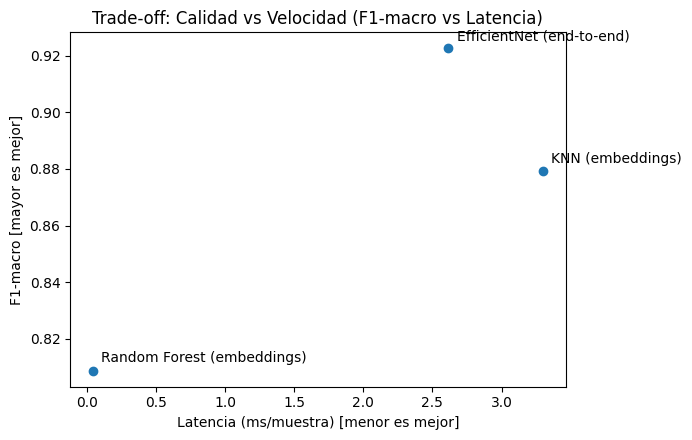

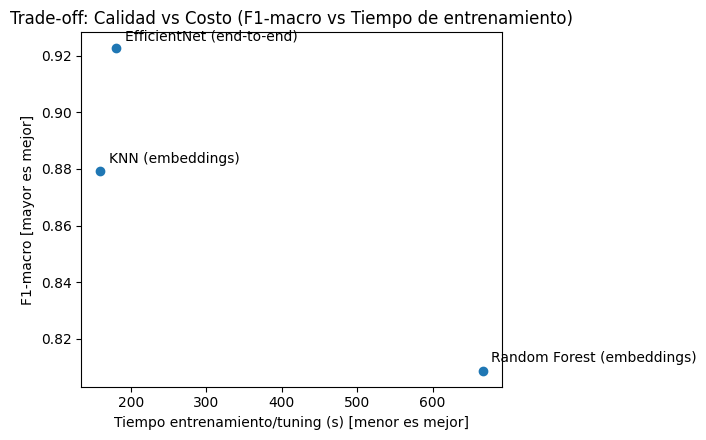

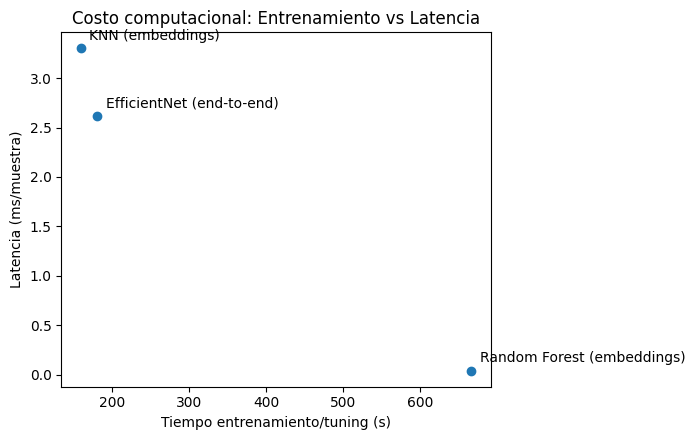

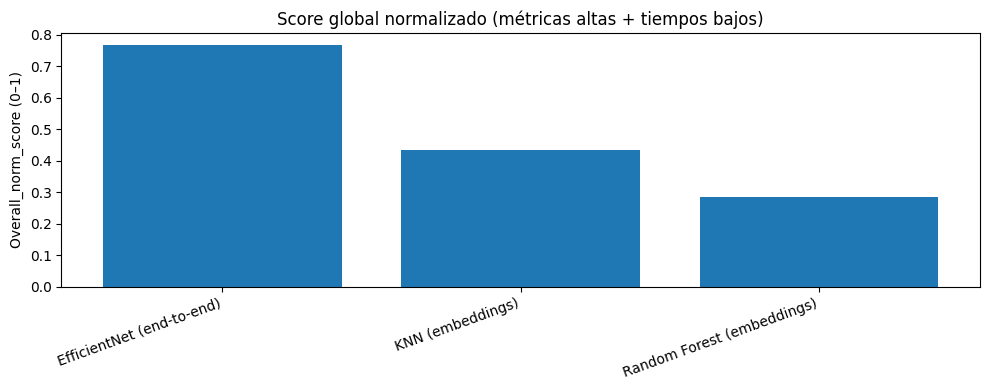

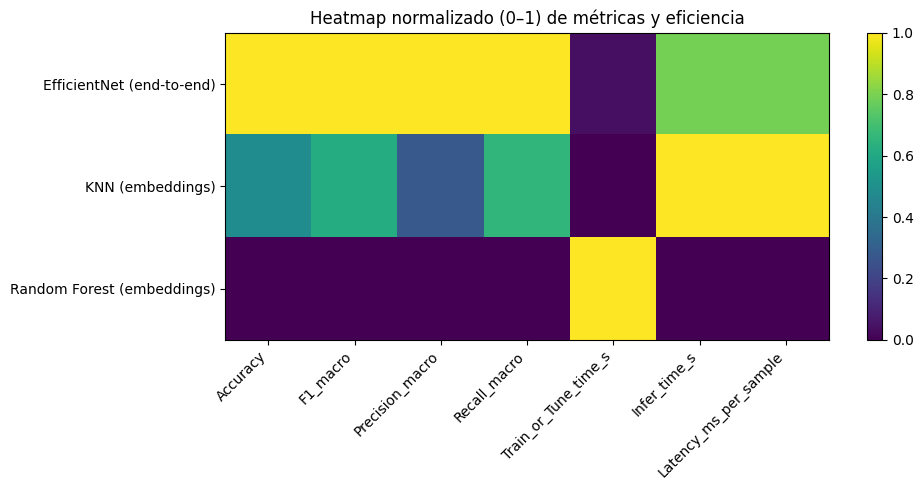

Metodo  Accuracy  F1_macro  Precision_macro  \
0   EfficientNet (end-to-end)  1.000000  1.000000         1.000000   
1            KNN (embeddings)  0.485232  0.618954         0.279726   
2  Random Forest (embeddings)  0.000000  0.000000         0.000000   

   Recall_macro  Train_or_Tune_time_s  Infer_time_s  Latency_ms_per_sample  
0      1.000000              0.042094      0.789916               0.789916  
1      0.658432              0.000000      1.000000               1.000000  
2      0.000000              1.000000      0.000000               0.000000

In [16]:
# ============================================
# BLOQUE 11.2 (CORREGIDO): Visualizaciones adicionales
# ============================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

assert "df_results" in globals(), "df_results no existe. Ejecuta el BLOQUE 11 primero."

df = df_results.copy()

# Columnas a analizar
cols_all = [
    "Accuracy", "F1_macro", "Precision_macro", "Recall_macro",
    "Train_or_Tune_time_s", "Infer_time_s", "Latency_ms_per_sample"
]

methods = df["Metodo"].tolist()

# Asegurar Score_tradeoff
if "Score_tradeoff" not in df.columns:
    eps = 1e-9
    f1_norm = (df["F1_macro"] - df["F1_macro"].min()) / (df["F1_macro"].max() - df["F1_macro"].min() + eps)
    lat_norm = (df["Latency_ms_per_sample"] - df["Latency_ms_per_sample"].min()) / (
        df["Latency_ms_per_sample"].max() - df["Latency_ms_per_sample"].min() + eps
    )
    df["Score_tradeoff"] = f1_norm - lat_norm

# ======================================================
# Helper: scatter con etiquetas
# ======================================================
def scatter_xy(xcol, ycol, title, xlabel, ylabel):
    x = df[xcol].values
    y = df[ycol].values

    plt.figure(figsize=(7, 4.5))
    plt.scatter(x, y)

    for i, m in enumerate(methods):
        plt.annotate(m, (x[i], y[i]), textcoords="offset points", xytext=(6, 6))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# ======================================================
# 1) F1 vs Latencia
# ======================================================
scatter_xy(
    xcol="Latency_ms_per_sample",
    ycol="F1_macro",
    title="Trade-off: Calidad vs Velocidad (F1-macro vs Latencia)",
    xlabel="Latencia (ms/muestra) [menor es mejor]",
    ylabel="F1-macro [mayor es mejor]"
)

# ======================================================
# 2) F1 vs Tiempo de entrenamiento/tuning
# ======================================================
scatter_xy(
    xcol="Train_or_Tune_time_s",
    ycol="F1_macro",
    title="Trade-off: Calidad vs Costo (F1-macro vs Tiempo de entrenamiento)",
    xlabel="Tiempo entrenamiento/tuning (s) [menor es mejor]",
    ylabel="F1-macro [mayor es mejor]"
)

# ======================================================
# 3) Latencia vs Tiempo de entrenamiento
# ======================================================
scatter_xy(
    xcol="Train_or_Tune_time_s",
    ycol="Latency_ms_per_sample",
    title="Costo computacional: Entrenamiento vs Latencia",
    xlabel="Tiempo entrenamiento/tuning (s)",
    ylabel="Latencia (ms/muestra)"
)

# ======================================================
# 4) Normalización 0–1 (para comparar escalas distintas)
# ======================================================
eps = 1e-9
df_norm = df[cols_all].copy()

for c in cols_all:
    df_norm[c] = (df_norm[c] - df_norm[c].min()) / (df_norm[c].max() - df_norm[c].min() + eps)

# Invertir métricas donde menor es mejor
df_norm_score = df_norm.copy()
for c in ["Train_or_Tune_time_s", "Infer_time_s", "Latency_ms_per_sample"]:
    df_norm_score[c] = 1.0 - df_norm_score[c]

# Score global normalizado
df_norm_score["Overall_norm_score"] = df_norm_score.mean(axis=1)

# ======================================================
# 5) Gráfico: Score global normalizado
# ======================================================
plt.figure(figsize=(10, 4))
x = np.arange(len(methods))
plt.bar(x, df_norm_score["Overall_norm_score"].values)
plt.xticks(x, methods, rotation=20, ha="right")
plt.title("Score global normalizado (métricas altas + tiempos bajos)")
plt.ylabel("Overall_norm_score (0–1)")
plt.tight_layout()
plt.show()

# ======================================================
# 6) Heatmap normalizado
# ======================================================
M = df_norm.values

plt.figure(figsize=(10, 5))
plt.imshow(M, aspect="auto", interpolation="nearest")
plt.colorbar()
plt.yticks(range(len(methods)), methods)
plt.xticks(range(len(cols_all)), cols_all, rotation=45, ha="right")
plt.title("Heatmap normalizado (0–1) de métricas y eficiencia")
plt.tight_layout()
plt.show()

# Mostrar tabla normalizada (opcional, útil para reporte)
display(pd.concat([df[["Metodo"]], df_norm], axis=1))



# BLOQUE 11.3  
## Pareto Front (F1-macro vs Latencia) + Ranking por dominancia

###  Objetivo del bloque
Este bloque agrega una visualización y análisis **tipo MLOps / optimización multiobjetivo**:

- **Objetivo 1:** maximizar **F1-macro** (calidad)
- **Objetivo 2:** minimizar **latencia** (ms/muestra) (eficiencia)

Se construye el **frente de Pareto**: modelos **no dominados**, es decir,
aquellos donde no existe otro modelo que sea **mejor o igual en todo**
y **estrictamente mejor en al menos un criterio**.

---

###  Interpretación
- Un modelo en el frente de Pareto es una opción racional según el trade-off.
- Si un modelo queda **dominado**, hay otro que lo supera en calidad y/o velocidad,
por lo que suele descartarse en decisiones de despliegue.


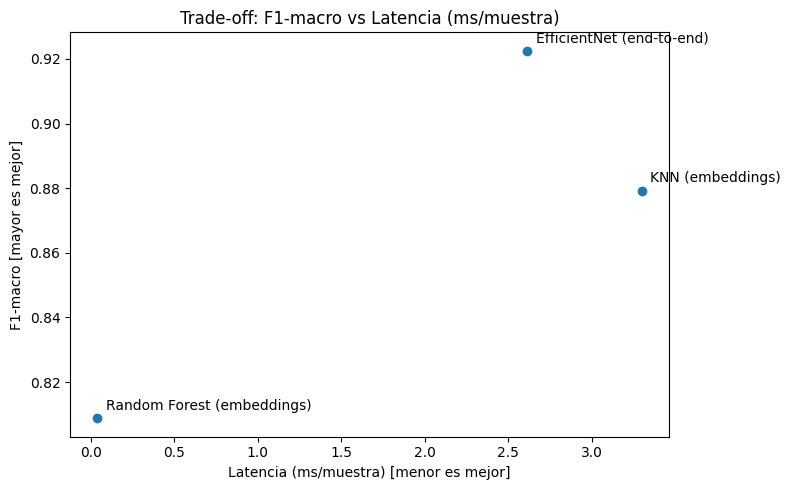

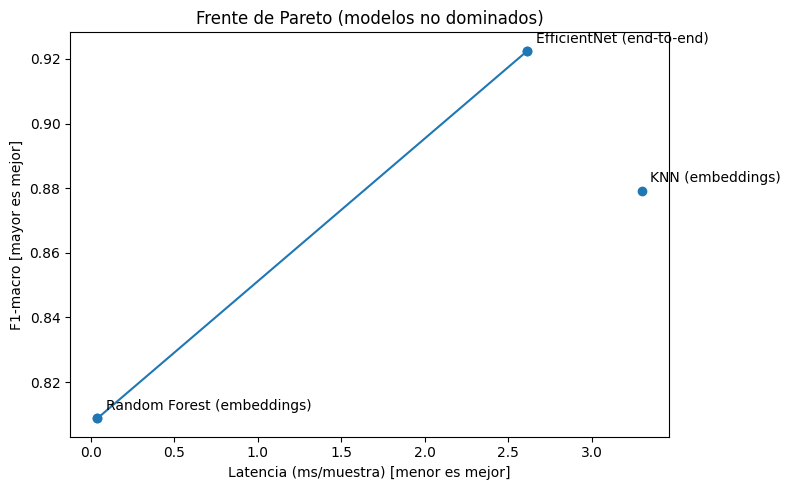

 Modelos en el Frente de Pareto (no dominados):
- Random Forest (embeddings) | F1-macro=0.8088 | Latencia=0.040 ms/muestra
- EfficientNet (end-to-end) | F1-macro=0.9225 | Latencia=2.616 ms/muestra

 Modelos dominados (existe otro mejor en F1 y/o latencia):
- KNN (embeddings)


In [17]:
# ============================================
# BLOQUE 11.3: Pareto Front (F1 vs Latencia)
# ============================================
import numpy as np
import matplotlib.pyplot as plt

assert "df_results" in globals(), "df_results no existe. Ejecuta el BLOQUE 11 primero."

df = df_results.copy()

# Variables objetivo
# - Queremos: F1 alto (maximizar)
# - Queremos: Latencia baja (minimizar)
methods = df["Metodo"].values
f1 = df["F1_macro"].values
lat = df["Latency_ms_per_sample"].values

# -------------------------------------------------------
# Función: determinar si un punto i es dominado por j
# Dominancia (multiobjetivo):
# j domina i si:
#   F1_j >= F1_i  y  Lat_j <= Lat_i
# y al menos una desigualdad es estricta
# -------------------------------------------------------
def is_dominated(i):
    for j in range(len(methods)):
        if j == i:
            continue
        if (f1[j] >= f1[i] and lat[j] <= lat[i]) and (f1[j] > f1[i] or lat[j] < lat[i]):
            return True
    return False

pareto_mask = np.array([not is_dominated(i) for i in range(len(methods))])
pareto_methods = methods[pareto_mask]
pareto_f1 = f1[pareto_mask]
pareto_lat = lat[pareto_mask]

# Ordenar Pareto por latencia (de menor a mayor)
order = np.argsort(pareto_lat)
pareto_methods = pareto_methods[order]
pareto_f1 = pareto_f1[order]
pareto_lat = pareto_lat[order]

# -------------------------------------------------------
# 1) Scatter general + destaque Pareto
# -------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(lat, f1)

for i, m in enumerate(methods):
    plt.annotate(m, (lat[i], f1[i]), textcoords="offset points", xytext=(6, 6))

plt.title("Trade-off: F1-macro vs Latencia (ms/muestra)")
plt.xlabel("Latencia (ms/muestra) [menor es mejor]")
plt.ylabel("F1-macro [mayor es mejor]")
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 2) Pareto Front (línea de no dominados)
# -------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(lat, f1)

# Dibujar línea del frente (ordenado por latencia)
plt.plot(pareto_lat, pareto_f1, marker="o")

for i, m in enumerate(methods):
    plt.annotate(m, (lat[i], f1[i]), textcoords="offset points", xytext=(6, 6))

plt.title("Frente de Pareto (modelos no dominados)")
plt.xlabel("Latencia (ms/muestra) [menor es mejor]")
plt.ylabel("F1-macro [mayor es mejor]")
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 3) Reporte Pareto + dominados
# -------------------------------------------------------
print(" Modelos en el Frente de Pareto (no dominados):")
for m, a, l in zip(pareto_methods, pareto_f1, pareto_lat):
    print(f"- {m} | F1-macro={a:.4f} | Latencia={l:.3f} ms/muestra")

dominated_methods = methods[~pareto_mask]
print("\n Modelos dominados (existe otro mejor en F1 y/o latencia):")
if len(dominated_methods) == 0:
    print("- Ninguno (todos son no dominados).")
else:
    for m in dominated_methods:
        print("-", m)


# BLOQUE 11.4  
## Visualización 3D: F1-macro vs Latencia vs Tiempo de entrenamiento/tuning

###  Objetivo del bloque
Este bloque crea una gráfica **3D** para analizar simultáneamente tres dimensiones clave:

- **Eje X:** Latencia (ms/muestra)  → *menor es mejor*
- **Eje Y:** Tiempo de entrenamiento/tuning (s) → *menor es mejor*
- **Eje Z:** F1-macro → *mayor es mejor*

Esto permite observar el compromiso global entre:
- calidad del modelo (F1),
- costo de ajuste (entrenamiento/tuning),
- eficiencia en inferencia (latencia).

---

###  Interpretación
- El modelo ideal se ubica hacia:
  - **Z alto** (F1 alto),
  - **X bajo** (latencia baja),
  - **Y bajo** (entrenamiento/tuning bajo).
- Si dos modelos tienen F1 similar, se prefiere el de menor latencia y menor costo de entrenamiento.


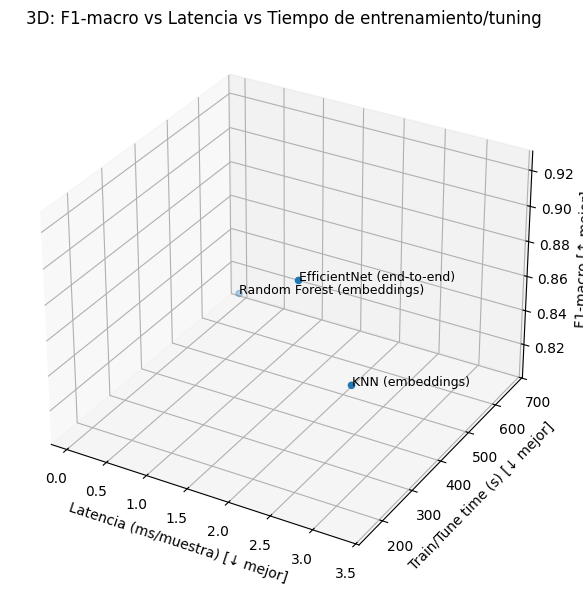

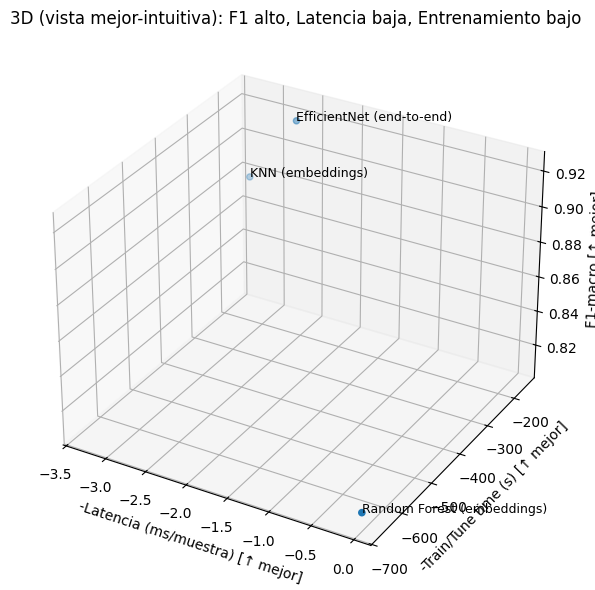

In [18]:
# ============================================
# BLOQUE 11.4: Gráfico 3D (F1 vs Latencia vs Train/Tune time)
# ============================================
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # necesario para proyección 3D

assert "df_results" in globals(), "df_results no existe. Ejecuta el BLOQUE 11 primero."

df = df_results.copy()

# Variables 3D
x = df["Latency_ms_per_sample"].values          # Latencia (ms/muestra) - menor mejor
y = df["Train_or_Tune_time_s"].values           # Entrenamiento/tuning (s) - menor mejor
z = df["F1_macro"].values                       # F1-macro - mayor mejor
methods = df["Metodo"].values

# Gráfico 3D
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x, y, z)

# Etiquetas por punto
for i, m in enumerate(methods):
    ax.text(x[i], y[i], z[i], m, fontsize=9)

ax.set_title("3D: F1-macro vs Latencia vs Tiempo de entrenamiento/tuning")
ax.set_xlabel("Latencia (ms/muestra) [↓ mejor]")
ax.set_ylabel("Train/Tune time (s) [↓ mejor]")
ax.set_zlabel("F1-macro [↑ mejor]")

plt.tight_layout()
plt.show()

# (Opcional) Vista alternativa: mismo gráfico pero con ejes invertidos para 'mejor' hacia arriba
# No cambia datos, solo ayuda a lectura conceptual.
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(-x, -y, z)  # invertir X,Y para que "mejor" (menor) se vea hacia el lado positivo

for i, m in enumerate(methods):
    ax.text(-x[i], -y[i], z[i], m, fontsize=9)

ax.set_title("3D (vista mejor-intuitiva): F1 alto, Latencia baja, Entrenamiento bajo")
ax.set_xlabel("-Latencia (ms/muestra) [↑ mejor]")
ax.set_ylabel("-Train/Tune time (s) [↑ mejor]")
ax.set_zlabel("F1-macro [↑ mejor]")

plt.tight_layout()
plt.show()


# BLOQUE 11.5  
## Gráfico de precisión (Precision) por modelo: macro vs por clase

###  Objetivo del bloque
Este bloque genera visualizaciones centradas en **precisión (Precision)** para cada modelo comparado:

1) **Precision-macro por modelo**  
   - Resume, en promedio, qué tan confiables son las predicciones positivas por clase (todas las clases pesan igual).

2) **Precisión por clase (comparación por modelo)**  
   - Permite detectar qué enfermedades tienden a generar más falsos positivos, y qué modelo los reduce mejor.
   - Es especialmente útil cuando algunas clases son visualmente similares y se confunden.

---

###  Interpretación correcta
- **Precision alta** implica menos falsos positivos: cuando el modelo predice una enfermedad, suele acertar.
- Si una clase tiene precision baja, el modelo está “sobre-prediciendo” esa clase (confunde otras con ella).
- Para análisis robusto se recomienda mirar:
  - precision macro (visión global) y
  - precision por clase (visión diagnóstica).

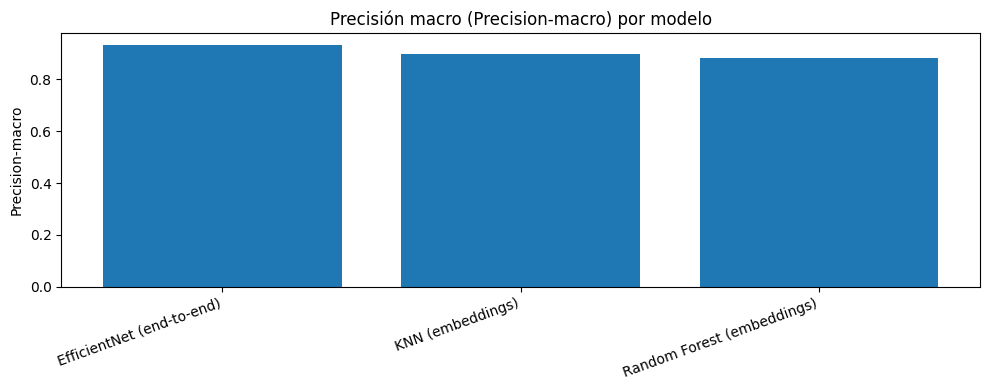

/tmp/ipython-input-4074606746.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


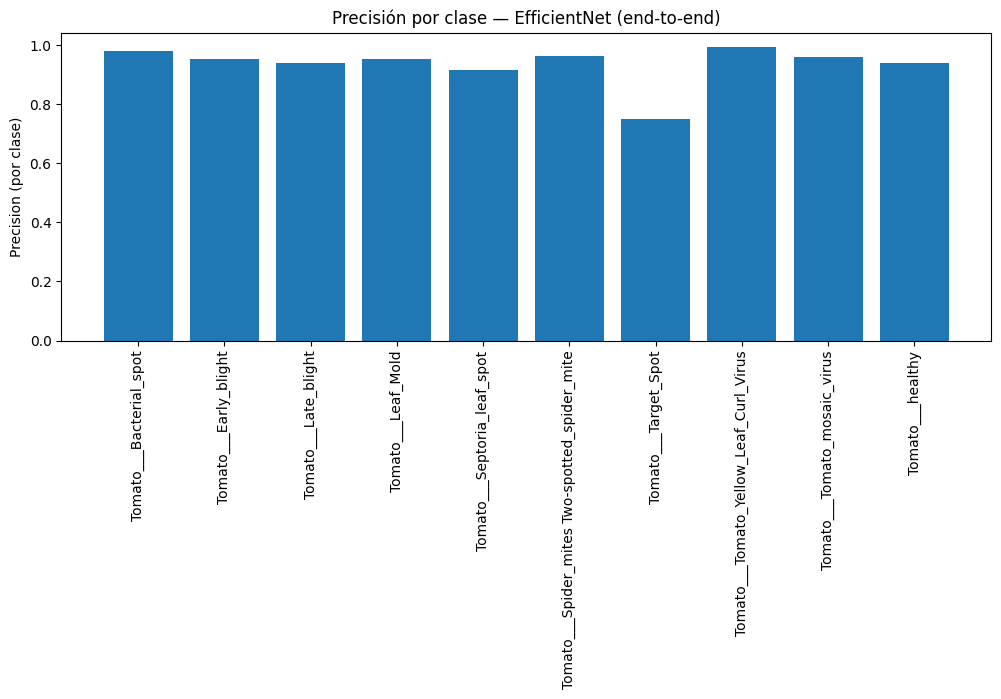

/tmp/ipython-input-4074606746.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


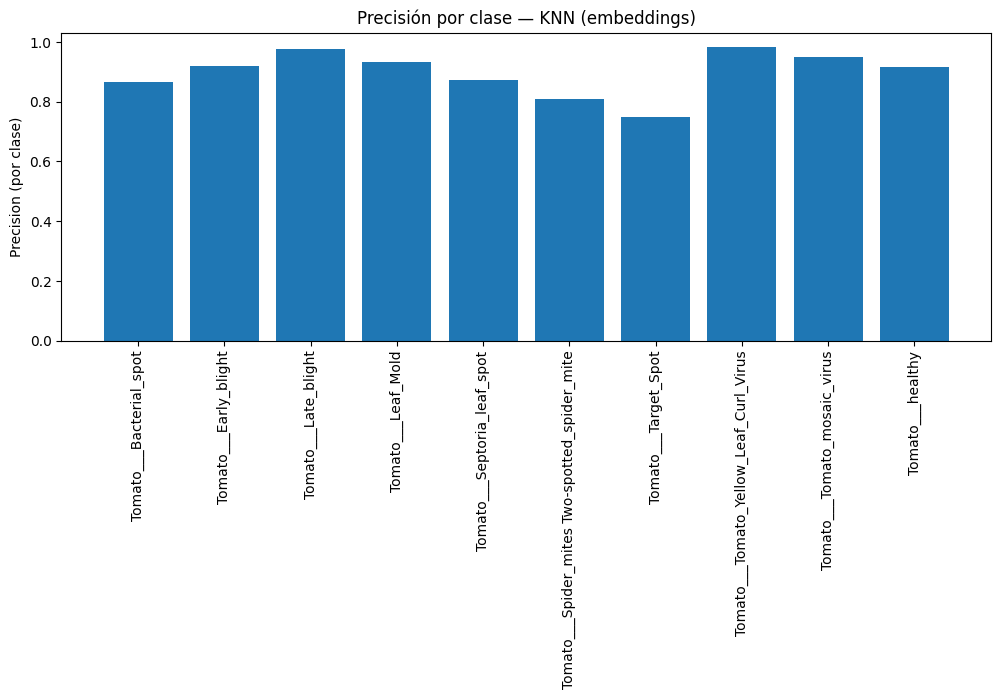

/tmp/ipython-input-4074606746.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


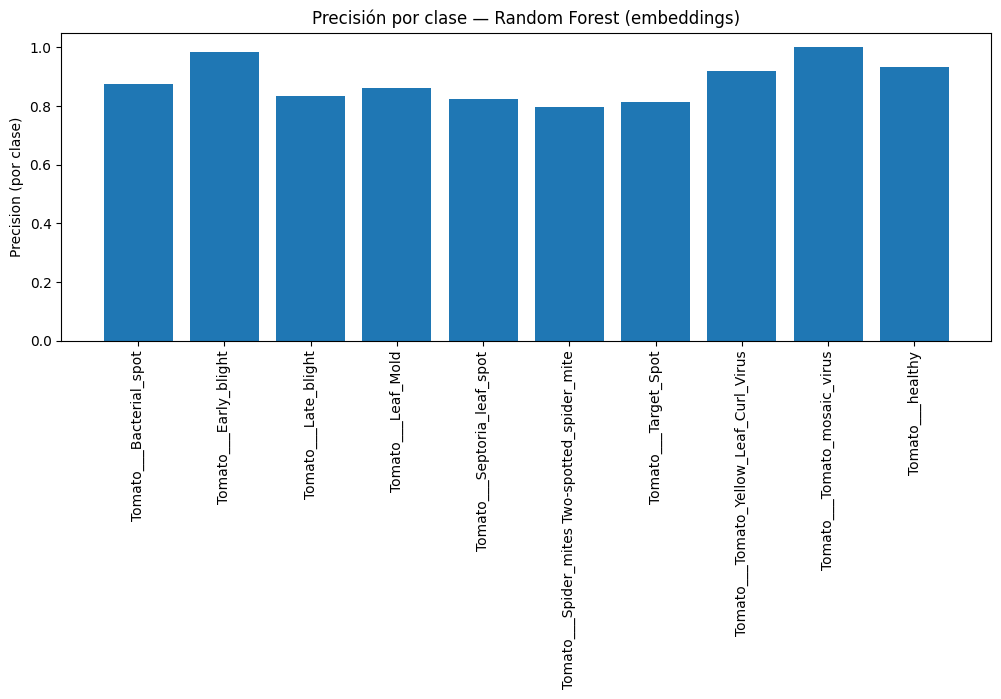

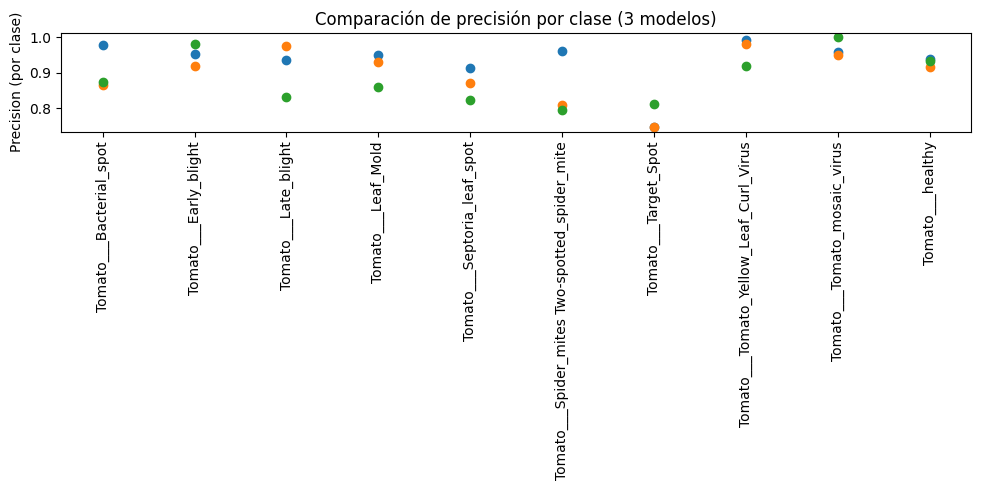

In [19]:
# ============================================
# BLOQUE 11.5: Precisión (Precision) por modelo y por clase
# ============================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

# Requisitos:
# - df_results con Precision_macro (BLOQUE 11)
# - y_test y predicciones por modelo: y_pred_eff, y_pred_knn, y_pred_rf
# - class_names
assert "df_results" in globals(), "df_results no existe. Ejecuta el BLOQUE 11."
for v in ["y_test", "class_names", "y_pred_eff", "y_pred_knn", "y_pred_rf"]:
    assert v in globals(), f"Falta {v}. Ejecuta BLOQUE 7 (EfficientNet), BLOQUE 9 (KNN), BLOQUE 10 (RF)."

# -------------------------------------------------------
# 1) Barra: Precision-macro por modelo
# -------------------------------------------------------
methods = df_results["Metodo"].tolist()
prec_macro = df_results["Precision_macro"].values

plt.figure(figsize=(10, 4))
x = np.arange(len(methods))
plt.bar(x, prec_macro)
plt.xticks(x, methods, rotation=20, ha="right")
plt.title("Precisión macro (Precision-macro) por modelo")
plt.ylabel("Precision-macro")
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 2) Precisión por clase (líneas separadas por modelo)
#    (3 gráficos: uno por modelo, para evitar subplots)
# -------------------------------------------------------
def precision_per_class(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None, zero_division=0)

prec_eff = precision_per_class(y_test, y_pred_eff)
prec_knn = precision_per_class(y_test, y_pred_knn)
prec_rf  = precision_per_class(y_test, y_pred_rf)

# Helper: barras por clase para un modelo (una figura por gráfico)
def barplot_per_class(values, title):
    plt.figure(figsize=(12, 4))
    idx = np.arange(len(class_names))
    plt.bar(idx, values)
    plt.xticks(idx, class_names, rotation=90)
    plt.title(title)
    plt.ylabel("Precision (por clase)")
    plt.tight_layout()
    plt.show()

barplot_per_class(prec_eff, "Precisión por clase — EfficientNet (end-to-end)")
barplot_per_class(prec_knn, "Precisión por clase — KNN (embeddings)")
barplot_per_class(prec_rf,  "Precisión por clase — Random Forest (embeddings)")

# -------------------------------------------------------
# 3) Comparación directa por clase (una clase = un punto, 3 modelos)
#    (un gráfico por clase sería demasiado; mejor un scatter comparativo)
# -------------------------------------------------------
plt.figure(figsize=(10, 5))
idx = np.arange(len(class_names))

plt.scatter(idx, prec_eff)
plt.scatter(idx, prec_knn)
plt.scatter(idx, prec_rf)

plt.xticks(idx, class_names, rotation=90)
plt.title("Comparación de precisión por clase (3 modelos)")
plt.ylabel("Precision (por clase)")
plt.tight_layout()
plt.show()


# BLOQUE 11.6  
## Costo computacional por modelo (entrenamiento/tuning + inferencia + latencia)

###  Objetivo del bloque
Este bloque genera gráficos para comparar el **costo computacional** de cada método considerando
las variables del BLOQUE 11:

- **Train_or_Tune_time_s**: tiempo de entrenamiento (EfficientNet) o búsqueda/ajuste (KNN/RF).
- **Infer_time_s**: tiempo total de inferencia sobre el conjunto test.
- **Latency_ms_per_sample**: latencia promedio por muestra (ms/img o ms/embedding).
- **Costo total aproximado**: suma `Train_or_Tune_time_s + Infer_time_s`.

---

###  Interpretación
- Si el objetivo es despliegue en IoT/Edge, la métrica más crítica suele ser **latencia**.
- Si el objetivo es iterar modelos rápidamente, importa más **Train_or_Tune_time_s**.
- El “costo total” sirve para tener una visión global del esfuerzo computacional del experimento.


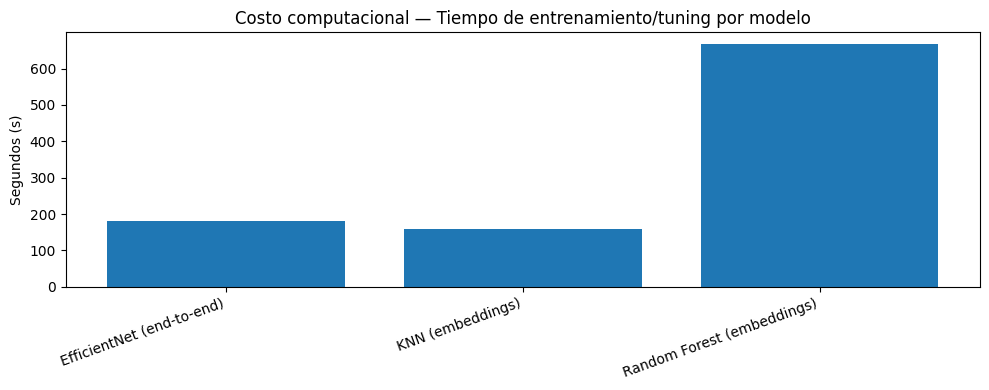

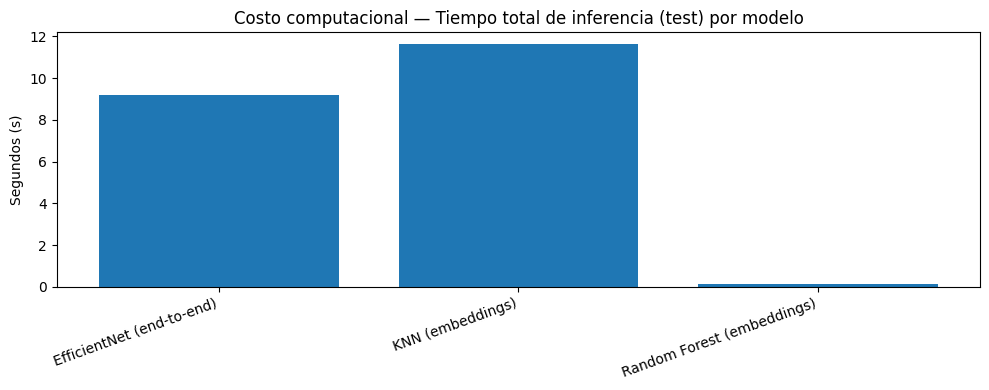

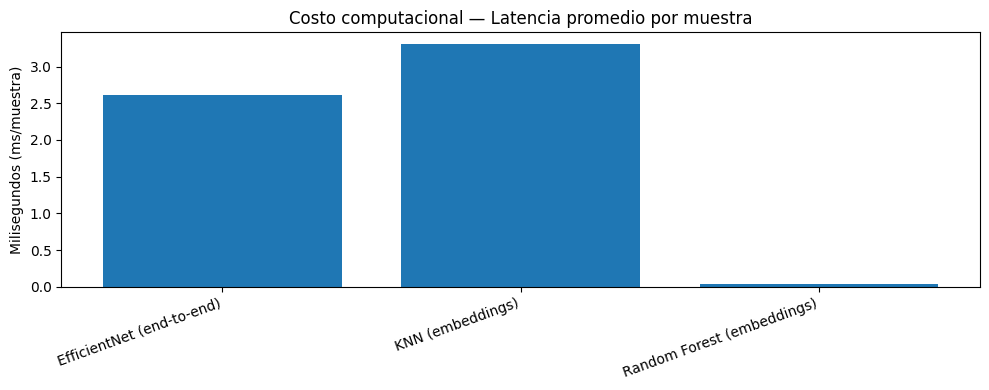

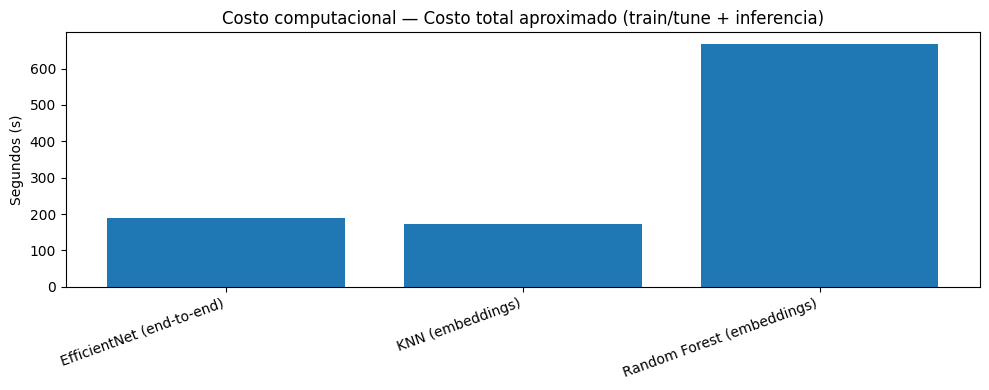

Metodo  Train_or_Tune_time_s  Infer_time_s  \
1            KNN (embeddings)            159.768403     11.609068   
0   EfficientNet (end-to-end)            181.086533      9.199919   
2  Random Forest (embeddings)            666.206256      0.141540   

   Latency_ms_per_sample  Total_cost_s  
1               3.300844    171.377471  
0               2.615843    190.286452  
2               0.040245    666.347796

In [20]:
# ============================================
# BLOQUE 11.6: Costo computacional por modelo
# ============================================
import numpy as np
import matplotlib.pyplot as plt

assert "df_results" in globals(), "df_results no existe. Ejecuta el BLOQUE 11 primero."

df = df_results.copy()
methods = df["Metodo"].tolist()

train_tune = df["Train_or_Tune_time_s"].values
infer_time = df["Infer_time_s"].values
lat_ms = df["Latency_ms_per_sample"].values

# 1) Tiempo de entrenamiento / tuning
plt.figure(figsize=(10, 4))
x = np.arange(len(methods))
plt.bar(x, train_tune)
plt.xticks(x, methods, rotation=20, ha="right")
plt.title("Costo computacional — Tiempo de entrenamiento/tuning por modelo")
plt.ylabel("Segundos (s)")
plt.tight_layout()
plt.show()

# 2) Tiempo total de inferencia en test
plt.figure(figsize=(10, 4))
plt.bar(x, infer_time)
plt.xticks(x, methods, rotation=20, ha="right")
plt.title("Costo computacional — Tiempo total de inferencia (test) por modelo")
plt.ylabel("Segundos (s)")
plt.tight_layout()
plt.show()

# 3) Latencia por muestra (ms)
plt.figure(figsize=(10, 4))
plt.bar(x, lat_ms)
plt.xticks(x, methods, rotation=20, ha="right")
plt.title("Costo computacional — Latencia promedio por muestra")
plt.ylabel("Milisegundos (ms/muestra)")
plt.tight_layout()
plt.show()

# 4) Costo total aproximado (train/tune + infer)
total_cost = train_tune + infer_time

plt.figure(figsize=(10, 4))
plt.bar(x, total_cost)
plt.xticks(x, methods, rotation=20, ha="right")
plt.title("Costo computacional — Costo total aproximado (train/tune + inferencia)")
plt.ylabel("Segundos (s)")
plt.tight_layout()
plt.show()

# 5) Tabla resumida (opcional)
import pandas as pd
df_cost = pd.DataFrame({
    "Metodo": methods,
    "Train_or_Tune_time_s": train_tune,
    "Infer_time_s": infer_time,
    "Latency_ms_per_sample": lat_ms,
    "Total_cost_s": total_cost
}).sort_values("Total_cost_s", ascending=True)

display(df_cost)


# BLOQUE 12  
## Inferencia final: subir una imagen y predecir con los 3 modelos (EfficientNet, KNN, Random Forest)

###  Objetivo del bloque
Este bloque permite subir una imagen desde el computador y evaluarla con los **tres enfoques** del experimento:

1) **EfficientNet (end-to-end)**  
   - Predice directamente desde píxeles.
   - Entrega **Top-5** (clases más probables) usando probabilidades softmax.

2) **KNN (embeddings)**  
   - La imagen se convierte a embedding (BLOQUE 8) y se clasifica con `best_knn`.
   - Entrega clase predicha y Top-5 usando `predict_proba` (si está disponible).

3) **Random Forest (embeddings)**  
   - Igual que KNN: embedding + `best_rf`.
   - Entrega clase predicha y Top-5 con probabilidades del ensamble.

---

###  Consideraciones técnicas
- Se usa el mismo `IMG_SIZE` definido en el pipeline.
- Para KNN/RF, se reutiliza el extractor `embed_model` del BLOQUE 8 (mismas features).
- Se asegura que las clases se interpreten consistentemente usando `class_names`.

---

###  Resultado esperado
Al subir una imagen se mostrará:
- la imagen cargada,
- la predicción de cada modelo,
- el Top-5 de clases por cada modelo (cuando aplique).


Saving Yellow_Leaf_Curl_Virus.JPG to Yellow_Leaf_Curl_Virus (1).JPG


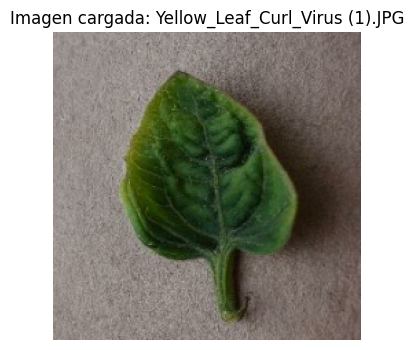


=== EfficientNet (end-to-end) ===
Predicción: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Top-5:
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.9996
 - Tomato___Leaf_Mold: 0.0001
 - Tomato___Bacterial_spot: 0.0001
 - Tomato___Target_Spot: 0.0000
 - Tomato___Spider_mites Two-spotted_spider_mite: 0.0000

=== KNN (embeddings) ===
Predicción: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Top-5:
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1.0000
 - Tomato___healthy: 0.0000
 - Tomato___Tomato_mosaic_virus: 0.0000
 - Tomato___Target_Spot: 0.0000
 - Tomato___Spider_mites Two-spotted_spider_mite: 0.0000

=== Random Forest (embeddings) ===
Predicción: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Top-5:
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.8491
 - Tomato___Bacterial_spot: 0.0401
 - Tomato___Target_Spot: 0.0276
 - Tomato___Spider_mites Two-spotted_spider_mite: 0.0203
 - Tomato___Leaf_Mold: 0.0201


In [27]:
# ============================================
# BLOQUE 12: Subir imagen y predecir con 3 modelos
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import files

# Requisitos previos
required = ["eff_model", "best_knn", "best_rf", "embed_model", "class_names", "IMG_SIZE"]
for v in required:
    assert v in globals(), f"Falta {v}. Ejecuta los bloques anteriores antes de inferir."

# ---------------------------------------------------------
# Helper: cargar y preparar imagen (mismo tamaño del modelo)
# ---------------------------------------------------------
def load_and_prepare_image(path, img_size):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)
    img = tf.expand_dims(img, axis=0)  # (1, H, W, 3)
    return img

# ---------------------------------------------------------
# Helper: top-k a partir de un vector de probabilidades
# ---------------------------------------------------------
def topk_from_proba(proba, k=5):
    idx = np.argsort(proba)[::-1][:k]
    return [(class_names[i], float(proba[i])) for i in idx]

# ---------------------------------------------------------
# Helper: inferencia EfficientNet (end-to-end)
# ---------------------------------------------------------
def predict_efficientnet(img_batch, topk=5):
    proba = eff_model.predict(img_batch, verbose=0)[0]  # (C,)
    pred_idx = int(np.argmax(proba))
    pred_label = class_names[pred_idx]
    return pred_label, topk_from_proba(proba, k=topk)

# ---------------------------------------------------------
# Helper: inferencia con KNN/RF vía embedding
# ---------------------------------------------------------
def predict_with_embedding(img_batch, model, topk=5):
    # embed_model recibe batch de imágenes y devuelve embedding (1, d)
    emb = embed_model.predict(img_batch, verbose=0)  # (1, d)
    pred_idx = int(model.predict(emb)[0])
    pred_label = class_names[pred_idx]

    # Top-k si el modelo soporta predict_proba
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(emb)[0]
        topk_list = topk_from_proba(proba, k=topk)
    else:
        topk_list = [(pred_label, 1.0)]  # fallback

    return pred_label, topk_list

# ---------------------------------------------------------
# 1) Subir imagen
# ---------------------------------------------------------
uploaded = files.upload()
img_path = next(iter(uploaded.keys()))

# 2) Mostrar imagen
img_batch = load_and_prepare_image(img_path, IMG_SIZE)
img_show = tf.cast(tf.squeeze(img_batch), tf.uint8).numpy()

plt.figure(figsize=(4, 4))
plt.imshow(img_show)
plt.title(f"Imagen cargada: {img_path}")
plt.axis("off")
plt.show()

# ---------------------------------------------------------
# 3) Predicción con los 3 modelos
# ---------------------------------------------------------
pred_eff, top5_eff = predict_efficientnet(img_batch, topk=5)
pred_knn, top5_knn = predict_with_embedding(img_batch, best_knn, topk=5)
pred_rf,  top5_rf  = predict_with_embedding(img_batch, best_rf, topk=5)

# ---------------------------------------------------------
# 4) Reporte en pantalla
# ---------------------------------------------------------
def print_topk(title, pred, topk_list):
    print(f"\n=== {title} ===")
    print("Predicción:", pred)
    print("Top-5:")
    for cls, p in topk_list:
        print(f" - {cls}: {p:.4f}")

print_topk("EfficientNet (end-to-end)", pred_eff, top5_eff)
print_topk("KNN (embeddings)", pred_knn, top5_knn)
print_topk("Random Forest (embeddings)", pred_rf, top5_rf)
